***
# PROJETO DE PREVISÃO DE VENDAS - REDE DE DROGARIAS 
## PARTE I: ANÁLISE EXPLORATÓRIA DE DADOS
***

### CONTEXTUALIZAÇÃO DO PROJETO:
***

O CFO da rede de drogarias solicitou uma previsão de vendas para obter informações precisas sobre o desempenho das lojas da rede e determinar o valor do investimento necessário para reformar cada uma. Será utilizado um conjunto de dados históricos de vendas diárias abrangendo dois anos e meio para prever as vendas diárias das 1.115 lojas da rede localizadas em diferentes partes da Alemanha para os próximos 42 dias. Essas previsões fornecerão informações sobre o valor total esperado das vendas em cada loja e a distribuição diária dessas vendas. O objetivo é fornecer informações confiáveis para ajudar a empresa a tomar decisões informadas sobre investimentos em reformas nas lojas.

**Premissas do negócio:**
    
    1. Apenas as lojas com vendas acima de zero foram consideradas para a previsão.

    2. Os dias em que as lojas estavam fechadas foram excluídos da previsão.

*O contexto, pessoas e perguntas são completamente fictícios.* O dataset utilizado para o projeto está disponível no **[Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales/data)**.

**SUMÁRIO EXECUTIVO**

**PARTE I**

**1. IMPORTS DE LIBRARIES E DATASET**

**2. EXPLORAÇÃO DO DATASET**
    
**3. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)**
   
    Hipóteses sobre os problemas definidos analisando visualmente os dados.
    1. Quais são as variáveis que impactam o fenômeno que estamos modelando?
    2. O que faz a venda diminuir e aumentar? 
    3. Verificar forças das correlações
    
**4. SPLIT DOS DADOS**

**5. PREPARAÇÃO DOS DADOS PARA O ALGORITMO BORUTA**
    
    1. Handling missing values
    2. Feature Engineering
    3. Pré-processamento dos dados
        - Rescaling
        - Encoding
    
**7. FEATURE SELECTION: BORUTA**

**8. PRÓXIMOS PASSOS**

# LOADING LIBRARIES

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
from scipy.stats import skew, kurtosis, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from dython.nominal import associations
import sidetable as stb
from dython.nominal import associations
import calendar

In [2]:
# Machine learning
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder,  FunctionTransformer
from sklearn.impute import SimpleImputer

In [207]:
# Configurações
plt.rcParams['figure.figsize'] = [15, 8]
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# FUNÇÕES AUXILIARES

In [150]:
def _range(series):
 return series.max() - series.min()

In [4]:
def day_week_month_transform(df):
    # Verifica se as colunas necessárias estão presentes no DataFrame
    required_cols = ['DayOfWeek', 'Month', 'Day', 'WeekOfYear']
    missing_cols = set(required_cols) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {missing_cols}")

    # Transforma o dia da semana em coordenadas polares para preservar a ordem circular
    df['DayOfWeek_sin'] = df['DayOfWeek'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
    df['DayOfWeek_cos'] = df['DayOfWeek'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

    # Transforma o mês em coordenadas polares para preservar a ordem circular
    df['Month_sin'] = df['Month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
    df['Month_cos'] = df['Month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

    # Transforma o dia do mês em coordenadas polares para preservar a ordem circular
    df['Day_sin'] = df['Day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
    df['Day_cos'] = df['Day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
    # Transforma a semana do ano em coordenadas polares para preservar a ordem circular
    df['WeekOfYear_sin'] = df['WeekOfYear'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
    df['WeekOfYear_cos'] = df['WeekOfYear'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

    return df

In [5]:
def handle_missing_values(df):
    """
    Realiza imputação de valores ausentes em um DataFrame.

    Parâmetros:
    -----------
    df : pandas.DataFrame
        O DataFrame a ser tratado.

    Retorna:
    --------
    pandas.DataFrame
        O DataFrame com valores ausentes imputados.
    """
    if not all(col in df.columns for col in [
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'
    ]):
        raise ValueError(
            "As colunas 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear' e 'PromoInterval devem estar presentes no DataFrame."
        )

    # Imputação para a coluna 'CompetitionOpenSinceMonth' com a estratégia de moda
    imputer = SimpleImputer(strategy='most_frequent')
    df.loc[:, 'CompetitionOpenSinceMonth'] = imputer.fit_transform(
        df[['CompetitionOpenSinceMonth']])

    # Imputação para a coluna 'CompetitionOpenSinceYear' com a estratégia de moda
    imputer = SimpleImputer(strategy='most_frequent')
    df.loc[:, 'CompetitionOpenSinceYear'] = imputer.fit_transform(
        df[['CompetitionOpenSinceYear']])

    # Imputação para a coluna 'CompetitionDistance' com a estratégia de mediana
    imputer = SimpleImputer(strategy='median')
    df.loc[:, 'CompetitionDistance'] = imputer.fit_transform(
        df[['CompetitionDistance']])

    # Substituição de valores ausentes por zero
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna(0, inplace=True)

    return df

# LOADING DATASET

In [4]:
# Dados históricos, incluindo a target vendas
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)

# Informações complementares sobre as lojas
df_store_raw = pd.read_csv('../data/raw/store.csv')

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# EXPLORAÇÃO DO DATASET 

In [8]:
print('Número de linhas:{}'.format(df_raw.shape[0]))
print('Número de colunas:{}'.format(df_raw.shape[1]))

Número de linhas:1017209
Número de colunas:18


In [12]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [13]:
df_raw.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.00,6.00,2014.00,1,31.00,2013.00,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.00,4.00,2006.00,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.00,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.00,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.00,NaN,NaN,1,22.00,2012.00,"Mar,Jun,Sept,Dec"


## Descrição das colunas do dataset

In [16]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

 Variável | Descrição
:------------|:---------
Store | ID exclusivo para cada loja
Sales | O volume de vendas de um determinado dia (variável que será prevista)
Customers | Número de clientes em um determinado dia
Open | Indicador para funcionamento da loja, aberta: 0 = fechada e 1 = aberta
StateHoliday | Feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Todas as escolas estão fechadas nos feriados e fins de semana. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
SchoolHoliday | Indica se store e date foram afetadas pelo fechamento de escolas públicas
StoreType | Diferencia entre os 4 modelos de loja diferentes (a, b, c, d)
Assortment | Descreve um nível de sortimento (a = basic, b = extra, c = extended)
Competition_distance | Distância em metros até a loja concorrente mais próxima
Competition_open_since (_month/_year) | Fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto
Promo | Indica se uma loja está realizando uma promoção naquele dia (0 = store is not participating, 1 = store is participating)
Promo2 | Promo2 é uma promoção contínua e consecutiva para algumas lojas (0 = store is not participating, 1 = store is participating)
Promo2_since(_year/_week) | Descreve o ano e a semana do calendário em que a loja começou a participar da promo2
Promo_interval | Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. E.g: "Feb,May,Aug,Nov" significa que cada rodada começa em February, May, August, November de qualquer ano para essa loja.

## Análise da qualidade dos dados

In [9]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,1017209.00,558.43,321.91,1.00,280.00,558.00,838.00,1115.00
DayOfWeek,1017209.00,4.00,2.00,1.00,2.00,4.00,6.00,7.00
Sales,1017209.00,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00
Customers,1017209.00,633.15,464.41,0.00,405.00,609.00,837.00,7388.00
Open,1017209.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00
Promo,1017209.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
SchoolHoliday,1017209.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00
CompetitionDistance,1014567.00,5430.09,7715.32,20.00,710.00,2330.00,6890.00,75860.00
CompetitionOpenSinceMonth,693861.00,7.22,3.21,1.00,4.00,8.00,10.00,12.00
CompetitionOpenSinceYear,693861.00,2008.69,5.99,1900.00,2006.00,2010.00,2013.00,2015.00


## Tipos de dados e conversão de tipo

In [245]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [10]:
df_raw.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [5]:
# Converter 'Date' para datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

In [18]:
# Check
df_raw.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## Dados ausentes

In [19]:
df_raw.stb.missing()

,missing,total,percent
PromoInterval,508031,1017209,49.94
Promo2SinceYear,508031,1017209,49.94
Promo2SinceWeek,508031,1017209,49.94
CompetitionOpenSinceYear,323348,1017209,31.79
CompetitionOpenSinceMonth,323348,1017209,31.79
CompetitionDistance,2642,1017209,0.26
DayOfWeek,0,1017209,0.00
Promo2,0,1017209,0.00
Assortment,0,1017209,0.00
Store,0,1017209,0.00


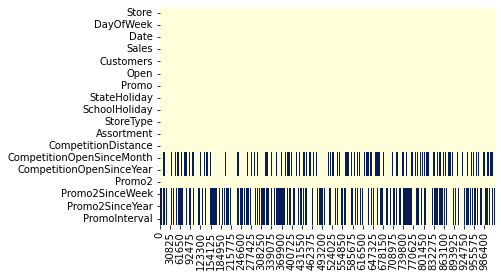

In [20]:
# Visualizando a distribuição dos missing values
sns.heatmap(df_raw.isnull().transpose(), cmap='YlGnBu', cbar=False);

In [15]:
len(df_raw.query('Promo2 == 0'))

508031

**O gráfico mostra visualmente que:**

- As colunas relacionadas a CompetitionOpenSinceMonth e CompetitionOpenSinceYear têm mais de 30% de valores ausentes. Nesse caso, prosseguiremos com a estratégia de preencher esses valores com o valor da moda. 
- A quantidade de valores ausentes foi muito alta para 'Promo2SinceWeek', 'Promo2SinceYear' e 'PromoInterval'.
- 508031 lojas não participaram da Promo2 e são as mesmas lojas com valores ausentes para as três variáveis. Portanto, os valores ausentes das colunas relacionadas a Promo2 serão preenchidos com 0. 

## Novas variáveis a partir da feature 'Date'

In [6]:
df1 = df_raw.copy()

In [22]:
# Year
df1['Year'] = df1['Date'].dt.year

# Month
df1['Month'] = df1['Date'].dt.month

# Day
df1['Day'] = df1['Date'].dt.day

# Week of year
df1['WeekOfYear'] = df1['Date'].dt.isocalendar().week

# Year Week
df1['YearWeek'] = df1['Date'].dt.strftime('%Y-%W')

# Dicionário com as estações do ano na Alemanha
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 
           6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

# Criação da coluna 'Season' com base na coluna 'Month'
df1['Season'] = df1['Month'].map(seasons)

In [14]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,YearWeek,Season
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,2015-30,Summer
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.00,2010.00,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,Summer
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.00,2011.00,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,Summer
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,31,2015-30,Summer
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,NaN,NaN,NaN,2015,7,31,31,2015-30,Summer


## Filtragem dos dados

A partir da análise da tabela com a descrição das variáveis, é possível observar que existem registros com valores nulos ou iguais a 0 para as variáveis Sales, Customers e Open. Tal fato pode ser explicado pelo fechamento temporário de algumas lojas para reformas ou em feriados, onde estas lojas não geraram vendas e, portanto, apresentam o valor zero para a variável Sales. A remoção dessas linhas se mostrou necessária para evitar potenciais interferências nos algoritmos de previsão e, consequentemente, garantir maior confiabilidade nos resultados. Além disso, tendo em vista que o recurso não estava agregando valor à previsão das vendas, decidiu-se pela sua completa remoção.

    1 - Quantas lojas estão fechadas?
    2 - Quantas lojas apresentaram valor de Sales = 0?
    3 - Quantas lojas apresentaram valor de Customers = 0?
    

In [20]:
store_closed = len(df1.query('Open == 0'))                             
print(f"1. Temos {store_closed} lojas fechadas.")

sales_0 = len(df1.query('Sales == 0'))
print(f"2. Temos {sales_0} lojas com vendas registradas como 0.")

customers_0 = len(df1.query('Customers == 0'))
print(f"3. Temos {customers_0} lojas com 0 clientes.")

1. Temos 172817 lojas fechadas.
2. Temos 172871 lojas com vendas registradas como 0.
3. Temos 172869 lojas com 0 clientes.


In [21]:
df1[['Open', 'StateHoliday', 'SchoolHoliday', 'Sales', 'Customers']
    ].groupby(['Open', 'StateHoliday', 'SchoolHoliday']).agg({'Sales': ['mean'], 'Customers': ['mean']}).stb.flatten()

,Open,StateHoliday,SchoolHoliday,Sales_mean,Customers_mean
0,0,0,0,0.00,0.00
1,0,0,1,0.00,0.00
2,0,a,0,0.00,0.00
3,0,a,1,0.00,0.00
4,0,b,0,0.00,0.00
5,0,b,1,0.00,0.00
6,0,c,1,0.00,0.00
7,1,0,0,6895.15,757.35
8,1,0,1,7196.90,781.77
9,1,a,0,8492.07,1266.11


In [22]:
df1[['Open', 'StoreType', 'Assortment', 'Sales', 'Customers']
    ].groupby(['Open', 'StoreType', 'Assortment']).agg({'Sales': ['mean'], 'Customers': ['mean']}).stb.flatten()

,Open,StoreType,Assortment,Sales_mean,Customers_mean
0,0,a,a,0.00,0.00
1,0,a,c,0.00,0.00
2,0,b,a,0.00,0.00
3,0,b,b,0.00,0.00
4,0,c,a,0.00,0.00
5,0,c,c,0.00,0.00
6,0,d,a,0.00,0.00
7,0,d,c,0.00,0.00
8,1,a,a,6537.62,759.24
9,1,a,c,7573.38,855.77


**Como premissa não consideraremos os dias com as lojas fechadas e vendas zeradas, ou seja, 'Open' == 0 & 'Sales' == 0.**

In [23]:
df2 = df1.copy()

In [24]:
# Filtragem
df2 = df2.loc[(df2['Open'] != 0)& (df2['Sales'] > 0)]

In [9]:
print('Número de linhas:{}'.format(df2.shape[0]))
print('Número de colunas:{}'.format(df2.shape[1]))

Número de linhas:844338
Número de colunas:18


In [12]:
df2.stb.missing()

,missing,total,percent
PromoInterval,423292,844338,50.13
Promo2SinceYear,423292,844338,50.13
Promo2SinceWeek,423292,844338,50.13
CompetitionOpenSinceMonth,268600,844338,31.81
CompetitionOpenSinceYear,268600,844338,31.81
CompetitionDistance,2186,844338,0.26
YearWeek,0,844338,0.00
WeekOfYear,0,844338,0.00
Day,0,844338,0.00
Month,0,844338,0.00


In [13]:
# Salvando o conjunto de dados filtrados
df2.to_csv("../data/processed/data_filtering.csv")

# ANÁLISE EXPLORATÓRIA DE DADOS

Diversos fatores podem influenciar o desempenho das vendas de uma rede de drogarias em lojas físicas. 
Como as expostas na imagem abaixo:

![Map hipoteses](../img/mind_map.png "Mapa Mental")

**HIPÓTESES**

**Clientes**

    a. As vendas podem ser diferentes dependendo do perfil dos clientes, como a faixa etária ou o 
    nível socioeconômico.
    b. Um maior número de clientes em uma determinada loja ou período resulta em mais vendas.
    
**Produtos**

    a. As vendas podem aumentar durante campanhas de marketing e promoções, como liquidações de estoque 
    ou descontos em compras.
    b. Um maior sortimento de produtos pode atrair diferentes tipos de clientes e aumentar a probabilidade
    de encontrar produtos que atendam às necessidades dos clientes. Em consequência, isso pode levar a um 
    aumento nas vendas.

**Localização da loja**

    a. As vendas podem ser afetadas pela presença de concorrentes nas proximidades ou pela abertura de novas
    lojas na região.
    b. As vendas podem variar dependendo da localização das lojas, como em áreas urbanas com alta densidade 
    populacional ou em bairros residenciais.
    
**Temporalidade**
    
    a. Dia da semana: as vendas podem ser maiores em certos dias da semana, como sexta-feira ou sábado, devido ao 
    aumento do tráfego de compradores nos finais de semana.
    b. Estação do ano: as vendas podem ser influenciadas por mudanças sazonais, como o aumento das vendas 
    de protetor solar no verão ou de vitaminas e remédios no inverno.
    c. Feriados também podem influenciar as vendas, com um aumento esperado nas vendas durante feriados 
    como Natal.

## Estatística descritiva

In [139]:
cat_attributes = df2.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

num_attributes = df2.select_dtypes(include=['int64', 'float64'])

### Features numéricas

In [149]:
# Medidas de tendência central e dispersão
num_attributes.agg(['mean', 'median', 'std', 'min', 'max', _range, 'skew',
                   'kurtosis'], skipna=True).T.reset_index().rename(columns={'index': 'Attributes'})

,Attributes,mean,median,std,min,max,_range,skew,kurtosis
0,Store,558.42,558.00,321.73,1.00,1115.00,1114.00,0.00,-1.20
1,DayOfWeek,3.52,3.00,1.72,1.00,7.00,6.00,0.02,-1.26
2,Sales,6955.96,6369.00,3103.82,46.00,41551.00,41505.00,1.59,4.85
3,Customers,762.78,676.00,401.19,8.00,7388.00,7380.00,2.79,13.32
4,Open,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
5,Promo,0.45,0.00,0.50,0.00,1.00,1.00,0.22,-1.95
6,SchoolHoliday,0.19,0.00,0.40,0.00,1.00,1.00,1.55,0.41
7,CompetitionDistance,5458.16,2320.00,7809.57,20.00,75860.00,75840.00,2.98,13.41
8,CompetitionOpenSinceMonth,7.22,8.00,3.21,1.00,12.00,11.00,-0.17,-1.25
9,CompetitionOpenSinceYear,2008.70,2010.00,5.98,1900.00,2015.00,115.00,-7.52,121.85


#### Histograma das variáveis numéricas: Vendas, Número de Clientes e Distância do Concorrente

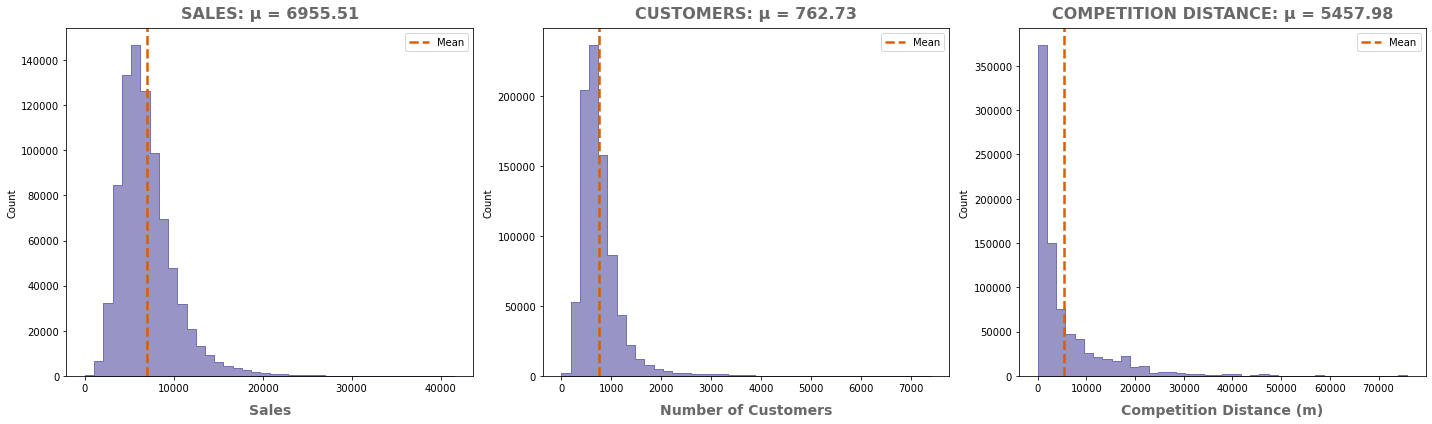

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(20, 6))
# Sales
sns.histplot(num_attributes.Sales, bins=40, element='step',
             color='#7570b3', ax=ax0)
ax0.set_xlabel('Sales', labelpad=10, fontsize=14,
               color='dimgrey', fontweight='bold')
ax0.axvline(x=num_attributes.Sales.mean(),
            label='Mean', color='#d95f02', ls='--', lw=2.5)
ax0.set_title('SALES: μ = 6955.51', fontsize=16, pad=10,
              color='dimgrey', fontweight='bold')
ax0.legend()

# Customers
sns.histplot(num_attributes.Customers, bins=40, element='step',
             color='#7570b3', ax=ax1)
ax1.set_xlabel('Number of Customers', labelpad=10,
               fontsize=14, color='dimgrey', fontweight='bold')
ax1.axvline(x=num_attributes.Customers.mean(),
            label='Mean', color='#d95f02', ls='--', lw=2.5)
ax1.set_title('CUSTOMERS: μ = 762.73', fontsize=16,
              pad=10, color='dimgrey', fontweight='bold')
ax1.legend()

# Competition Distance
sns.histplot(num_attributes.CompetitionDistance, element='step',
             bins=40, color='#7570b3', ax=ax2)
ax2.set_xlabel('Competition Distance (m)', labelpad=10,
               fontsize=14, color='dimgrey', fontweight='bold')
ax2.axvline(x=num_attributes.CompetitionDistance.mean(),
            label='Mean', color='#d95f02', ls='--', lw=2.5)
ax2.set_title('COMPETITION DISTANCE: μ = 5457.98', fontsize=16,
              pad=10, color='dimgrey', fontweight='bold')
ax2.legend();

fig.tight_layout()

- CompetitionDistance apresenta skewness positiva. A partir dessa observação, adotarei a estratégia de imputar os dados ausentes com o valor da mediana que é menos sensível a outliers.

### Features categóricas

In [30]:
cat_attributes.head()

,StateHoliday,StoreType,Assortment,WeekOfYear,YearWeek,Season
0,0,c,a,31,2015-30,Summer
1,0,a,a,31,2015-30,Summer
2,0,a,a,31,2015-30,Summer
3,0,c,c,31,2015-30,Summer
4,0,a,a,31,2015-30,Summer


In [31]:
# Número de valores exclusivos para cada variável categórica
cat_attributes.nunique()

StateHoliday      4
StoreType         4
Assortment        3
WeekOfYear       52
YearWeek        137
Season            4
dtype: int64

In [32]:
#holidays = df2[df2['StateHoliday'] != '0']

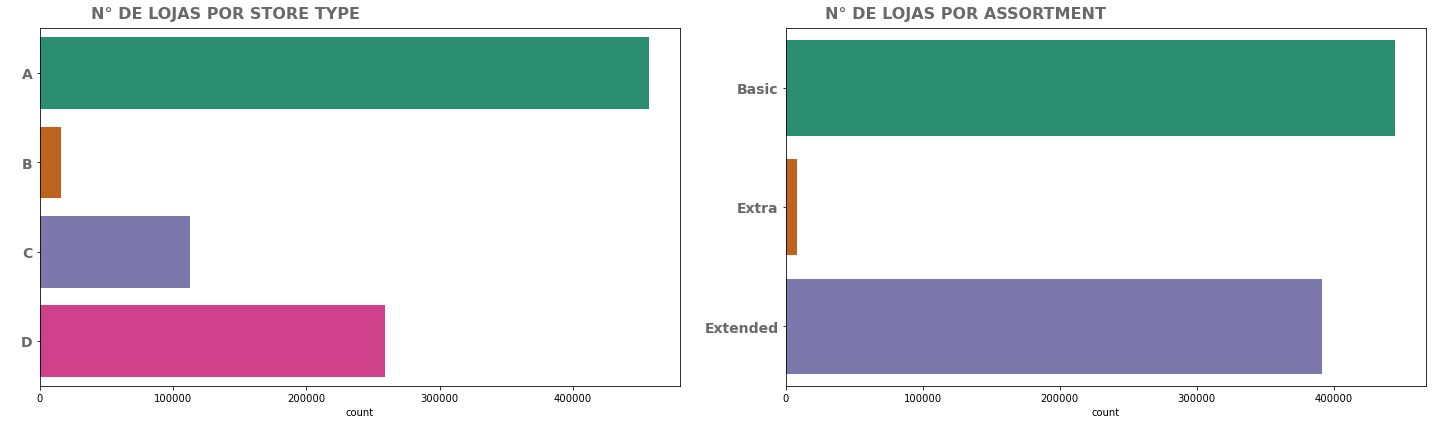

In [33]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Store Type
sns.countplot(y='StoreType', data=df2, palette='Dark2',
              order=['a', 'b', 'c', 'd'], ax=ax0)
ax0.set_yticklabels(['A', 'B', 'C', 'D'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_ylabel(' ')
ax0.set_title('N° DE LOJAS POR STORE TYPE', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold', ha='right')

# Assortment
sns.countplot(y='Assortment', data=df2, palette='Dark2',
              order=['a', 'b', 'c'], ax=ax1)
ax1.set_yticklabels(['Basic', 'Extra', 'Extended'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel(' ')
ax1.set_title('N° DE LOJAS POR ASSORTMENT', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold', ha='right')

fig.tight_layout()

In [34]:
# StoreType pode assumir os valores a, b, c ou d.
df2.stb.freq(['StoreType'])

,StoreType,count,percent,cumulative_count,cumulative_percent
0,a,457077,54.13,457077,54.13
1,d,258774,30.65,715851,84.78
2,c,112978,13.38,828829,98.16
3,b,15563,1.84,844392,100.00


In [35]:
# Assortment descreve um nível de sortimento da loja.
# a = basic, b = extra, c = extended
df2.stb.freq(['Assortment'])

,Assortment,count,percent,cumulative_count,cumulative_percent
0,a,444909,52.69,444909,52.69
1,c,391271,46.34,836180,99.03
2,b,8212,0.97,844392,100.00


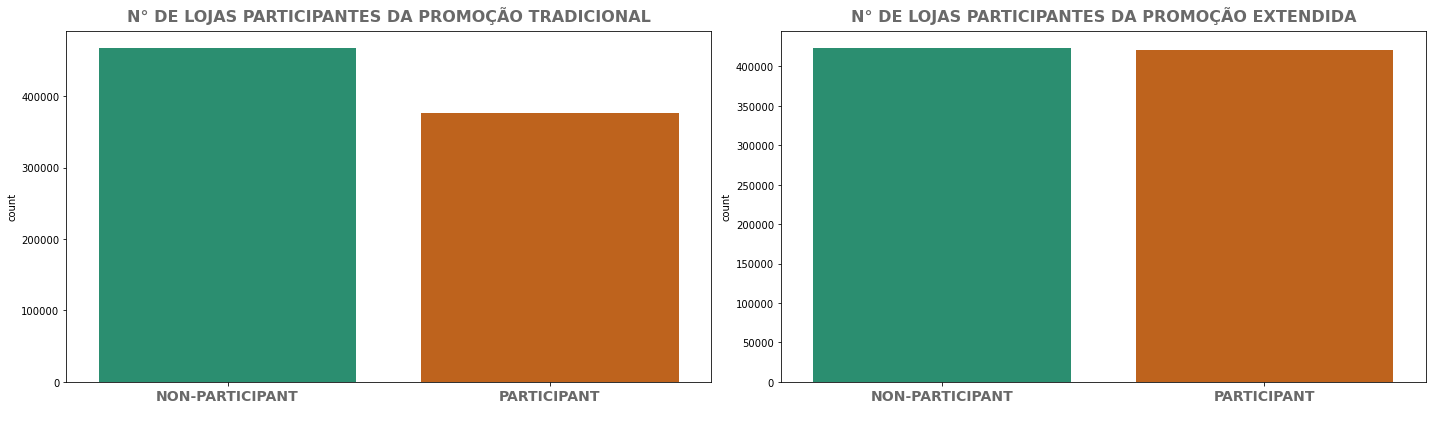

In [36]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))

# Promo
sns.countplot(x='Promo', data=df2, palette='Dark2', ax=ax0)
ax0.set_xticklabels(['NON-PARTICIPANT', 'PARTICIPANT'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_xlabel(' ')
ax0.set_title('N° DE LOJAS PARTICIPANTES DA PROMOÇÃO TRADICIONAL', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')

# Promo2
sns.countplot(x='Promo2', data=df2, palette='Dark2', ax=ax1)
ax1.set_xticklabels(['NON-PARTICIPANT', 'PARTICIPANT'],
                    fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_xlabel(' ')
ax1.set_title('N° DE LOJAS PARTICIPANTES DA PROMOÇÃO EXTENDIDA', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold');

fig.tight_layout()

In [37]:
# Promo
df2.stb.freq(['Promo'])

,Promo,count,percent,cumulative_count,cumulative_percent
0,0,467496,55.36,467496,55.36
1,1,376896,44.64,844392,100.00


In [38]:
# Promo
df2.stb.freq(['Promo2'])

,Promo2,count,percent,cumulative_count,cumulative_percent
0,0,423307,50.13,423307,50.13
1,1,421085,49.87,844392,100.00


In [154]:
# SchoolHoliday pode assumir os seguintes valores: 
# 0 ou 1
df2.stb.freq(['SchoolHoliday'])

,SchoolHoliday,count,percent,cumulative_count,cumulative_percent
0,0,680893,80.64,680893,80.64
1,1,163445,19.36,844338,100.00


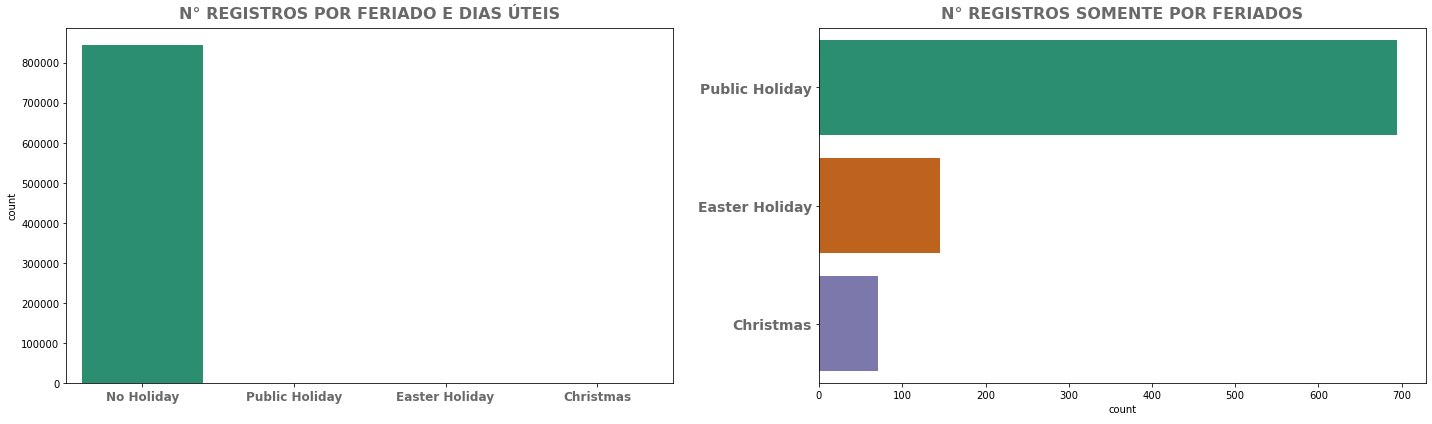

In [39]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))
# StateHoliday
sns.countplot(x='StateHoliday', data=df2, palette='Dark2', ax=ax0)
ax0.set_xticklabels(
    ['No Holiday','Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=12, color='dimgrey', fontweight='bold')
ax0.set_xlabel(' ')
ax0.set_title('N° REGISTROS POR FERIADO E DIAS ÚTEIS', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')

# Excluindo os registros dos dias úteis
holidays = df2[df2['StateHoliday'] != '0']
sns.countplot(y='StateHoliday', data=holidays, palette='Dark2', ax=ax1)
ax1.set_yticklabels(
    ['Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel(' ')
ax1.set_title('N° REGISTROS SOMENTE POR FERIADOS', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold');

fig.tight_layout()

In [40]:
# StateHoliday pode assumir os seguintes valores: 
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2.stb.freq(['StateHoliday'])

,StateHoliday,count,percent,cumulative_count,cumulative_percent
0,0,843482,99.89,843482,99.89
1,a,694,0.08,844176,99.97
2,b,145,0.02,844321,99.99
3,c,71,0.01,844392,100.00


In [41]:
# SchoolHoliday pode assumir os seguintes valores: 
# 0 ou 1
df2.stb.freq(['SchoolHoliday'])

,SchoolHoliday,count,percent,cumulative_count,cumulative_percent
0,0,680935,80.64,680935,80.64
1,1,163457,19.36,844392,100.00


## Hipóteses sobre localização

### Lojas com concorrentes mais próximos vendem menos
**Relação não encontrada**

Era esperado que a presença de concorrentes próximos, resultaria em uma redução nas vendas e no número de clientes, uma vez que os consumidores têm mais opções de escolha e podem optar por comprar em uma loja concorrente mais próxima. 

No entanto, a análise sugere que não há influência da distância de lojas competidoras para a média de vendas. Outros fatores, como localização, preço, promoções, entre outros, podem estar exercendo uma influência maior sobre as vendas. Podemos consideras hipóteses alternativas que expliquem esse resultado, tais como:

1. Preços competitivos: talvez a loja em questão tenha preços mais competitivos em relação aos seus concorrentes, independentemente da distância;

2. Diferenciação de produto: a loja pode oferecer produtos ou serviços que se destacam dos concorrentes próximos, atraindo clientes mesmo que haja lojas competidoras próximas;

3. Fidelização de clientes: a loja pode ter uma base de clientes fiéis que preferem comprar naquela loja, independentemente da distância ou de outras opções de concorrentes próximos;

4. Localização privilegiada: a loja pode estar em uma localização privilegiada, que compensa a proximidade dos concorrentes, atraindo um fluxo maior de clientes;

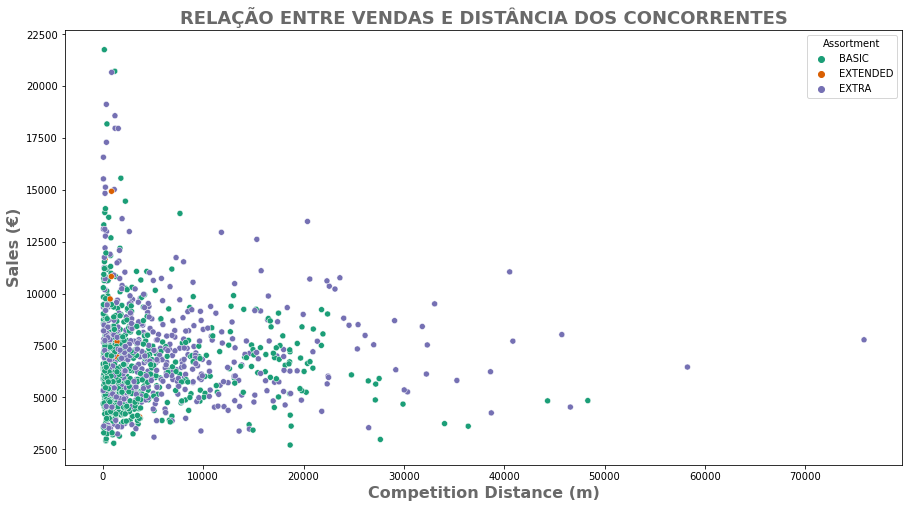

In [163]:
# Criar o dicionário de mapeamento das categorias para os nomes desejados
assortment_labels = {'a': 'BASIC', 'b': 'EXTENDED', 'c': 'EXTRA'}

# Agrupar as vendas por loja e calcular a média das vendas em cada grupo
sales_by_store = df2[['Store', 'Sales', 'CompetitionDistance', 'Assortment']].groupby(
    ['Store', 'CompetitionDistance', 'Assortment'])['Sales'].mean().reset_index()

# Plotar o gráfico de dispersão com a média das vendas por loja
sns.scatterplot(x='CompetitionDistance', y='Sales',
                hue='Assortment', hue_order=['a', 'b', 'c'], data=sales_by_store, palette='Dark2')

# Configurando as legendas do eixo x e y
plt.xlabel('Competition Distance (m)', fontsize=16,
           color='dimgrey', fontweight='bold')
plt.ylabel('Sales (€)', fontsize=16, color='dimgrey', fontweight='bold')

# Adicionando título
plt.title('RELAÇÃO ENTRE VENDAS E DISTÂNCIA DOS CONCORRENTES',
         fontsize=18,color='dimgrey', fontweight='bold')

# Atribuir os rótulos personalizados ao legend da legenda
handles, labels = plt.gca().get_legend_handles_labels()
labels = [assortment_labels[label] for label in labels]
plt.legend(handles, labels, title='Assortment');

In [64]:
# Criando agrupamentos para as distâncias
c_dist = df2[['CompetitionDistance', 'Sales']].groupby(
    'CompetitionDistance').mean().reset_index()
bins = list(np.arange(0, 40000, 500))
c_dist['CompetitionDistanceBinned'] = pd.cut(
    c_dist['CompetitionDistance'], bins=bins)
c_dist_grouped = c_dist[['CompetitionDistanceBinned', 'Sales']].groupby(
    'CompetitionDistanceBinned').mean().reset_index()

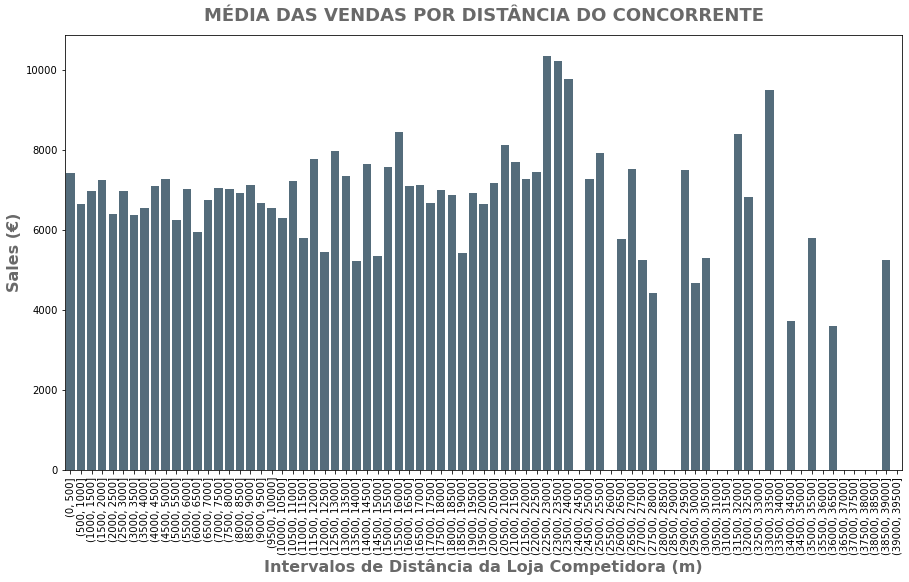

In [162]:
# Plotando o gráfico de barras
sns.barplot(x='CompetitionDistanceBinned',
            y='Sales', data=c_dist_grouped, color='#4e6e81')
plt.xlabel('Intervalos de Distância da Loja Competidora (m)', fontsize=16, color='dimgrey', fontweight='bold')               
plt.ylabel('Sales (€)', fontsize=16, color='dimgrey', fontweight='bold')
plt.title('MÉDIA DAS VENDAS POR DISTÂNCIA DO CONCORRENTE',
         pad=14, fontsize=18, color='dimgrey', fontweight='bold')
plt.xticks(rotation=90);

### Lojas com competidores mais próximos atraem menos clientes

**Relação não encontrada**

Com base na análise de dados realizada, foi constatado que as lojas com concorrentes mais próximos são as que registraram mais clientes, contrariando a expectativa inicial de que essas lojas atraíssem menos clientes. Além disso, a distância de 33000 a 33500 metros registrou em média um maior número de clientes em comparação com os outros intervalos, e são as lojas do tipo extra com maior variedade de produtos vendidos.

Algumas hipóteses alternativas que podem explicar esses resultados são:

1. Localização privilegiada das lojas com concorrentes próximos, como centros comerciais, pode facilitar o acesso dos clientes;
2. Lojas com concorrentes mais próximos podem esta localizadas em áreas com maior densidade populacional, o que pode explicar o maior número de clientes registrados. 
3. Maior variedade de produtos vendidos nas lojas extra, que podem atrair clientes que buscam opções diferenciadas;
4. A presença de concorrentes próximos pode aumentar a demanda por produtos específicos em uma determinada região, beneficiando todas as lojas que oferecem esses produtos;
5. A proximidade de concorrentes pode estimular a competição e o desenvolvimento de estratégias comerciais mais eficazes, o que pode levar a um aumento geral nas vendas.

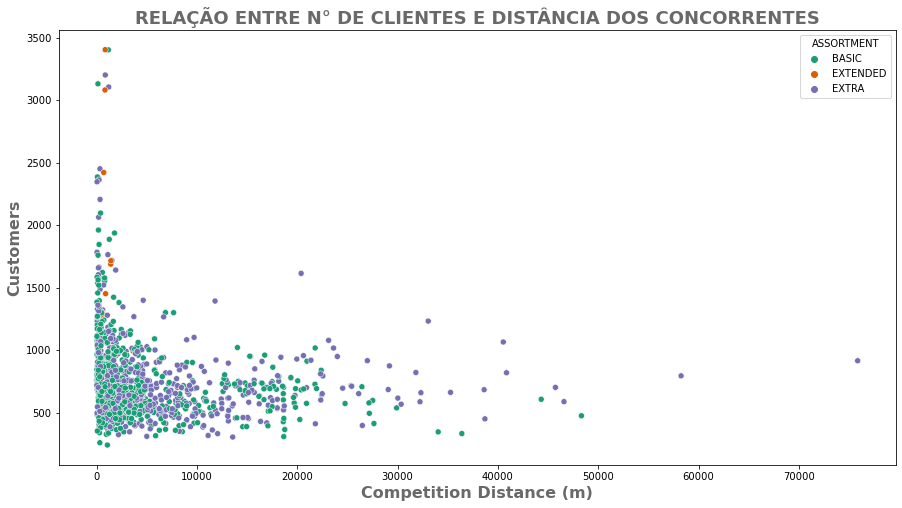

In [62]:
# Criar o dicionário de mapeamento das categorias para os nomes desejados
assortment_labels = {'a': 'BASIC', 'b': 'EXTENDED', 'c': 'EXTRA'}

# Agrupar as vendas por loja e calcular a média das vendas em cada grupo
customers_by_store = df2[['Store', 'Customers', 'CompetitionDistance', 'Assortment']].groupby(
    ['Store', 'CompetitionDistance', 'Assortment'])['Customers'].mean().reset_index()

# Plotar o gráfico de dispersão com a média do número de clientes por loja
sns.scatterplot(x='CompetitionDistance', y='Customers',
                hue='Assortment', hue_order=['a', 'b', 'c'], data=customers_by_store, palette='Dark2')

# Configurando as legendas do eixo x e y
plt.xlabel('Competition Distance (m)', fontsize=16,
           color='dimgrey', fontweight='bold')
plt.ylabel('Customers', fontsize=16, color='dimgrey', fontweight='bold')

# Adicionando título
plt.title('RELAÇÃO ENTRE N° DE CLIENTES E DISTÂNCIA DOS CONCORRENTES',
         fontsize=18,color='dimgrey', fontweight='bold')

# Atribuir os rótulos personalizados ao legend da legenda
handles, labels = plt.gca().get_legend_handles_labels()
labels = [assortment_labels[label] for label in labels]
plt.legend(handles, labels, title='ASSORTMENT');

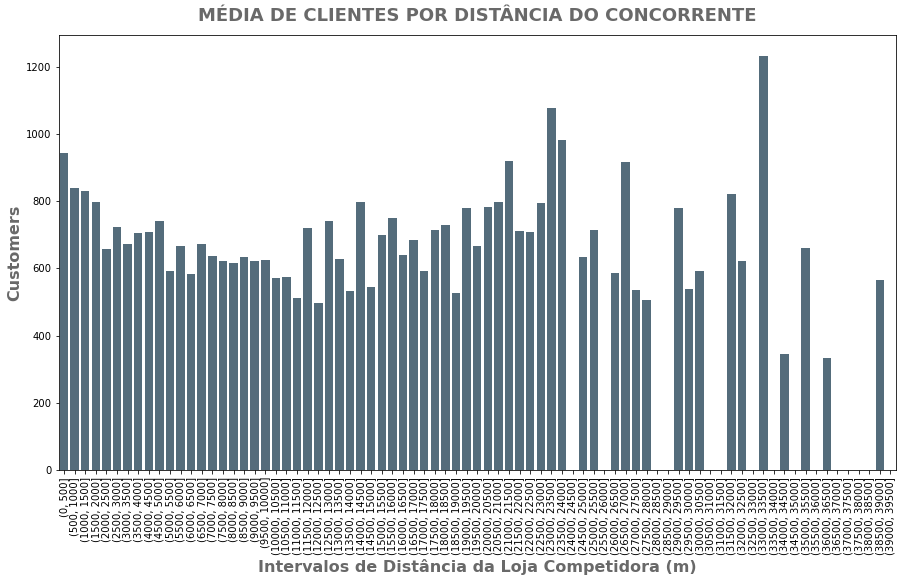

In [161]:
# Criando agrupamentos para as distâncias
cust_dist = df2[['CompetitionDistance', 'Customers']].groupby(
    'CompetitionDistance').mean().reset_index()
bins = list(np.arange(0, 40000, 500))
cust_dist['CompetitionDistanceBinned'] = pd.cut(
    cust_dist['CompetitionDistance'], bins=bins)
cust_dist_grouped = cust_dist[['CompetitionDistanceBinned', 'Customers']].groupby(
    'CompetitionDistanceBinned').mean().reset_index()

# Plotando o gráfico de barras
sns.barplot(x='CompetitionDistanceBinned',
            y='Customers', data=cust_dist_grouped, color='#4e6e81')
plt.xlabel('Intervalos de Distância da Loja Competidora (m)', fontsize=16, color='dimgrey', fontweight='bold')               
plt.ylabel('Customers', fontsize=16, color='dimgrey', fontweight='bold')
plt.title('MÉDIA DE CLIENTES POR DISTÂNCIA DO CONCORRENTE',
         pad=14, fontsize=18, color='dimgrey', fontweight='bold')
plt.xticks(rotation=90);

## Hipóteses sobre produto

### Store Type

Apesar de não termos informações sobre o significado da variável 'StoreType', é possível observar visualmente no boxplot que as lojas do tipo b apresentam um maior número de vendas em comparação aos outros tipos de lojas, mesmo representando apenas 1.84% da base de dados. Existem diversos fatores que poderiam explicar o observado na análise, tais como a localização, estratégia de precificação e variedade de produtos.

Analisando cada tipo de loja em relação à média geral de vendas de € 6955.95, temos: lojas do tipo A com média de vendas de € 6925.70 (-0.44% em relação à média geral); lojas do tipo B com média de vendas de € 10233.38 (+47.12% em relação à média geral); lojas do tipo C com média de vendas de € 6933.13 (-0.33% em relação à média geral); e lojas do tipo D com média de vendas de € 6822.20 (-1.92% em relação à média geral).

Na Alemanha, a rede Rossmann oferece diversos formatos de lojas que podem estar relacionados aos diferentes tipos de lojas da base de dados. Por exemplo, lojas do formato *Rossmann Ideenwelt* são focadas em produtos eletrônicos e de tecnologia. Lojas desse tipo mesmo que em menor quantidade, podem apresentar um maior valor de vendas médio por possuírem produtos de alto valor agregado em relação a outros tipos de lojas da rede. No entanto, é necessário realizar mais análises e investigações para entender melhor os fatores que contribuem para o sucesso das lojas do tipo b. Além disso, é fundamental realizar testes estatísticos, como análise de variância, para confirmar se as diferenças observadas são reais e estatisticamente significantes.

In [17]:
df2[['StoreType','Sales']].groupby(['StoreType']).agg({'Sales': ['mean', 'sum']}).stb.flatten()

,StoreType,Sales_mean,Sales_sum
0,a,6925.70,3165334859
1,b,10233.38,159231395
2,c,6933.13,783221426
3,d,6822.30,1765392943


In [195]:
# Calcular a média de vendas para cada tipo de loja
mean_a = df2[df2['StoreType'] == 'a']['Sales'].mean()
mean_b = df2[df2['StoreType'] == 'b']['Sales'].mean()
mean_c = df2[df2['StoreType'] == 'c']['Sales'].mean()
mean_d = df2[df2['StoreType'] == 'd']['Sales'].mean()

# Calcular a variação percentual para cada tipo de loja em relação à média geral
mean_all = df2['Sales'].mean()
var_pct_a = (mean_a - mean_all) / mean_all * 100
var_pct_b = (mean_b - mean_all) / mean_all * 100
var_pct_c = (mean_c - mean_all) / mean_all * 100
var_pct_d = (mean_d - mean_all) / mean_all * 100

print(f"Variação percentual para a loja tipo a: {var_pct_a:.2f}%")
print(f"Variação percentual para a loja tipo b: {var_pct_b:.2f}%")
print(f"Variação percentual para a loja tipo c: {var_pct_c:.2f}%")
print(f"Variação percentual para a loja tipo d: {var_pct_d:.2f}%")

Variação percentual para a loja tipo a: -0.44%
Variação percentual para a loja tipo b: 47.12%
Variação percentual para a loja tipo c: -0.33%
Variação percentual para a loja tipo d: -1.92%


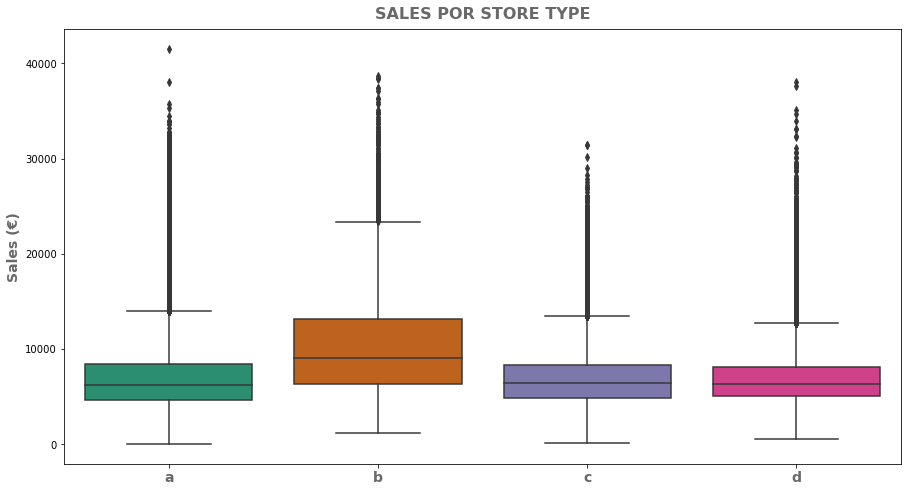

In [159]:
store_t = sns.boxplot(x='StoreType', y='Sales', data=df2,
                     palette='Dark2', order=['a', 'b', 'c', 'd'])
store_t.set_xticklabels(['a', 'b', 'c', 'd'],
                       fontsize=14, color='dimgrey', fontweight='bold')
store_t.set_xlabel('')
store_t.set_ylabel('Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
store_t.set_title('SALES POR STORE TYPE', pad=10,
                 fontsize=16, color='dimgrey', fontweight='bold');

### Lojas com maior sortimento apresentam maiores valores de venda.

   Um maior sortimento de produtos pode atrair diferentes tipos de clientes e aumentar a probabilidade de encontrar produtos que atendam às suas necessidades e consequentemente aumentar as vendas.
   
   Na análise, as lojas com sortimento extra apresentaram uma média um pouco maior em comparação às lojas de sortimento basic e extended. Apesar de representarem uma pequena porcentagem das lojas da base de dados (0.92%), isso pode indicar que há outros fatores que estão influenciando as vendas dessas lojas. Algumas hipóteses alternativas que podem ser consideradas incluem:

1. Foco em um nicho de mercado: as lojas podem estar oferecendo produtos que atendem a uma demanda específica de um nicho de mercado, o que pode estar atraindo um público fiel e gerando mais vendas.

2. Localização estratégica: pode ser que as lojas de sortimento extra estejam localizadas em regiões com maior fluxo de pessoas ou em áreas que atendem a um público específico, o que pode estar contribuindo para o aumento das vendas.

Destaco que essas hipóteses são apenas algumas possibilidades e que outras explicações podem ser encontradas por meio de uma análise mais aprofundada dos dados e da investigação de outros fatores que possam estar influenciando as vendas. Além disso, é fundamental realizar testes estatísticos para confirmar se as diferenças observadas são estatisticamente significantes.

In [19]:
df2[['Assortment','Sales']].groupby(['Assortment']).agg({'Sales': ['mean', 'sum']}).stb.flatten()

,Assortment,Sales_mean,Sales_sum
0,a,6621.52,2945750070
1,b,8642.50,70946312
2,c,7300.84,2856484241


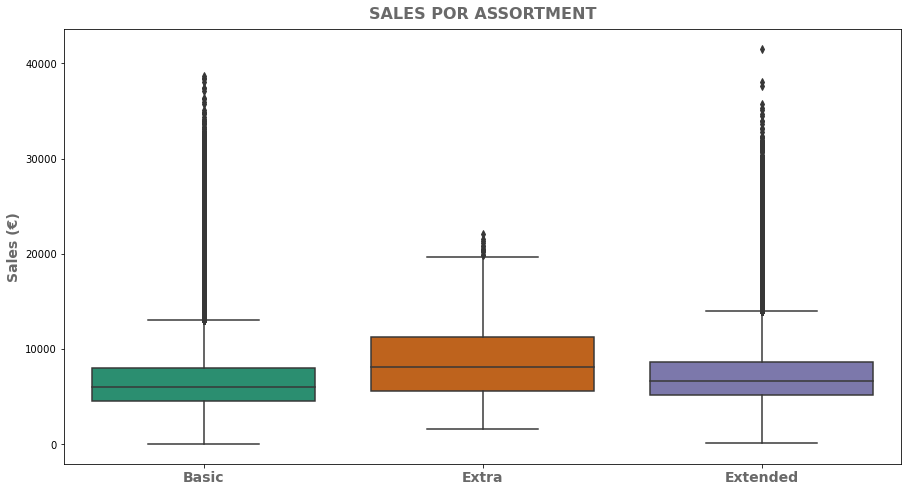

In [158]:
assort = sns.boxplot(x='Assortment', y='Sales', data=df2,
                     palette='Dark2', order=['a', 'b', 'c'])
assort.set_xticklabels(['Basic', 'Extra', 'Extended'],
                       fontsize=14, color='dimgrey', fontweight='bold')
assort.set_xlabel('')
assort.set_ylabel('Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
assort.set_title('SALES POR ASSORTMENT', pad=10,
                 fontsize=16, color='dimgrey', fontweight='bold');

**HÁ VARIAÇÃO NAS VENDAS POR SORTIMENTO DE LOJA AO LONGO DOS ANOS?**

 No gráfico de linhas, podemos observar que as vendas para lojas com assortment Basic (a) e assortment Extended (c) variaram entre 15000000 e 25000000 ao longo das semanas do ano. Já para as lojas do tipo Extra (b), que apresentam uma quantidade menor de lojas, houve uma variação entre 400000 e 600000. Para os três tipos de sortimento de lojas, houve uma queda considerável nas vendas na última semana de dezembro (2013-52) e na primeira semana de janeiro (2015-00), a semana de 2013-00 também apresentou um dos pontos mais baixos de vendas.

Esses resultados podem ser explicados por diversas hipóteses, como:

1. Efeito sazonal: é possível que a queda nas vendas na última semana de dezembro e primeira semana de janeiro seja influenciada pela sazonalidade das festas de fim de ano e do Ano Novo, onde muitas pessoas estão viajando ou ocupadas com outros compromissos.
2. Efeito do clima: mudanças climáticas como frio intenso, tempestades ou ondas de calor podem afetar as vendas de certos tipos de produtos, como roupas, alimentos e bebidas.
3. Efeito da concorrência: é possível que outras lojas próximas ou sites de comércio eletrônico estejam oferecendo descontos ou promoções durante esse período, o que pode afetar as vendas das lojas em questão.
4. Localização: lojas em áreas mais urbanas ou turísticas podem ter um desempenho melhor durante o período de fim de ano devido ao aumento do tráfego de pessoas.
5. Estratégia de marketing: é possível que as lojas estejam ajustando sua estratégia de marketing durante esse período para atrair mais clientes ou oferecer promoções mais agressivas.

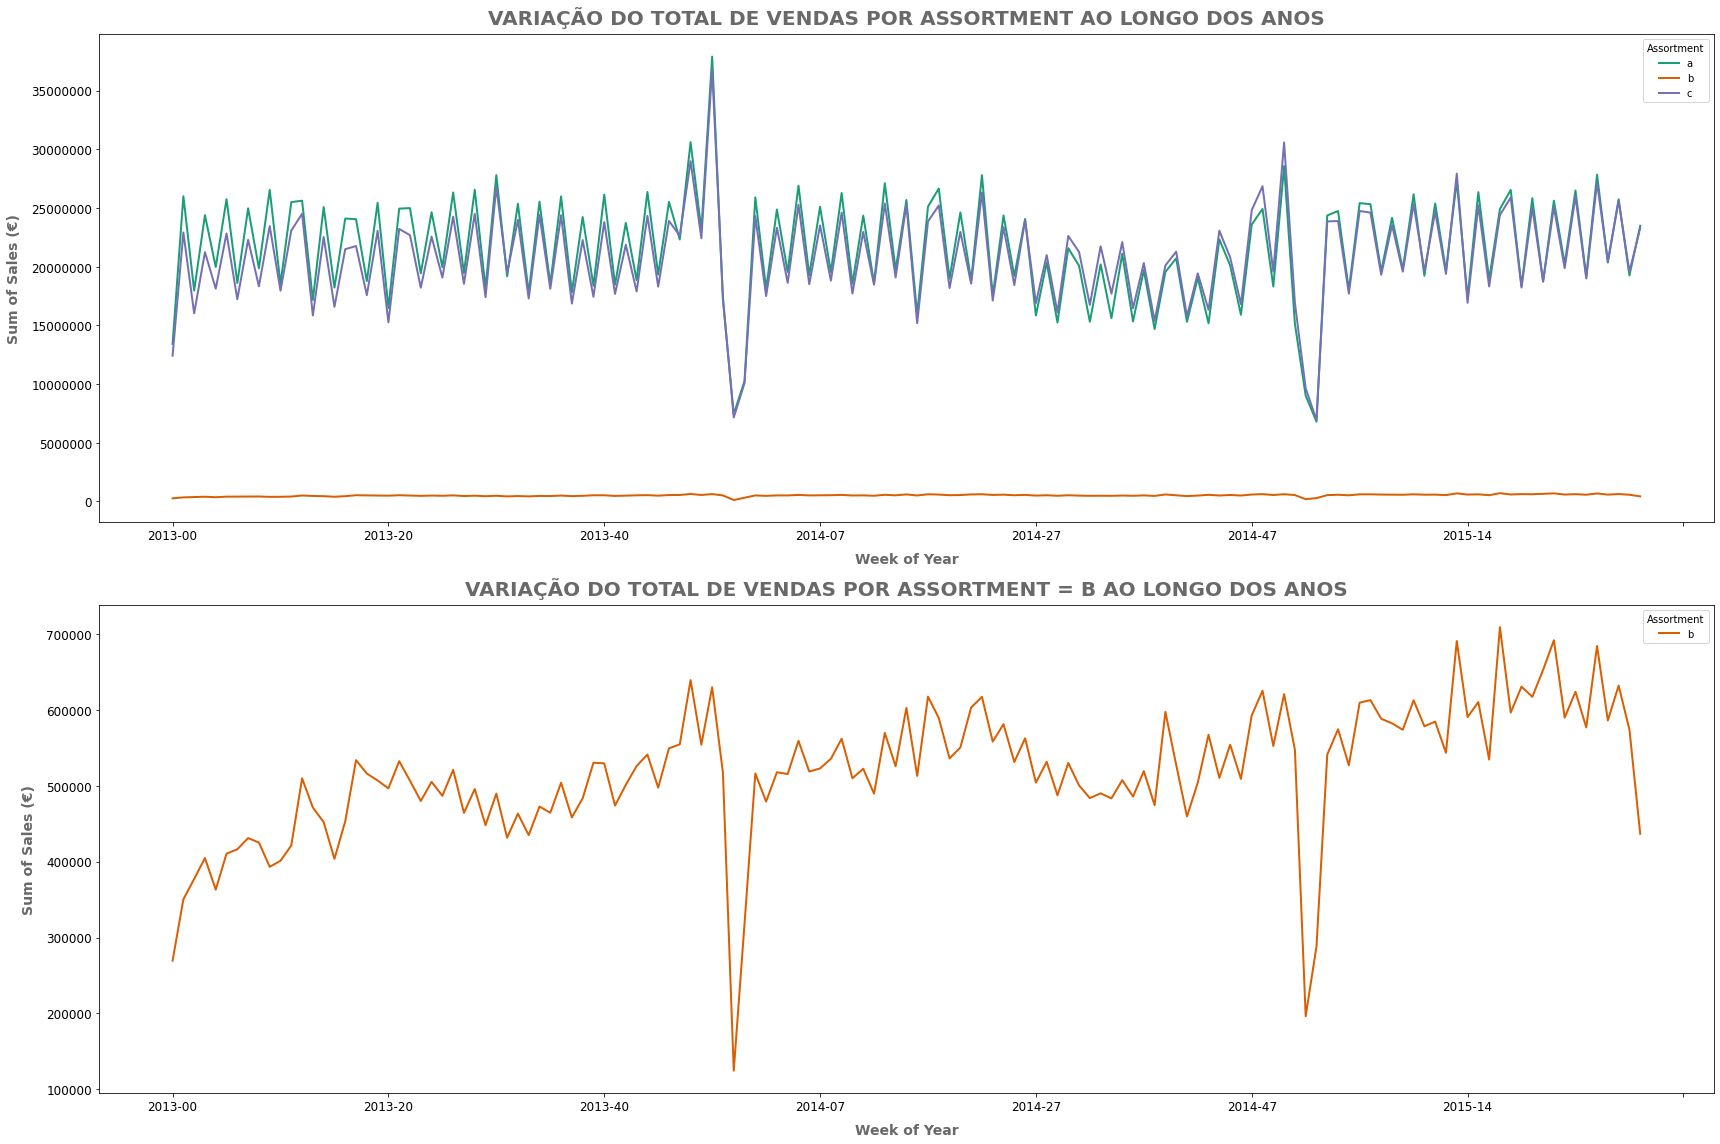

In [157]:
# Agrupando os dados
sales_assort = df2[['YearWeek', 'Assortment', 'Sales']].groupby(
    ['YearWeek', 'Assortment']).sum().reset_index()

# Definindo a paleta de cores
colors = sns.color_palette('Dark2', n_colors=len(
    sales_assort['Assortment'].unique()))

# Criando os gráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(24, 16))
axes = axes.flatten()

for i, (assortment, data) in enumerate(sales_assort.groupby('Assortment')):
    data.pivot(index='YearWeek', columns='Assortment',
               values='Sales').plot(fontsize=12, linewidth=2, color=colors[i], ax=axes[0])
    axes[0].set_xlabel('Week of Year', labelpad=10, fontsize=14,
                       color='dimgrey', fontweight='bold')
    axes[0].set_ylabel('Sum of Sales (€)', labelpad=10, fontsize=14,
                       color='dimgrey', fontweight='bold')
    axes[0].set_title('VARIAÇÃO DO TOTAL DE VENDAS POR ASSORTMENT AO LONGO DOS ANOS',
                      pad=10, fontsize=20, color='dimgrey', fontweight='bold')
    axes[0].ticklabel_format(style='plain', axis='y')

    if assortment == 'b':
        data.pivot(index='YearWeek', columns='Assortment',
                   values='Sales').plot(fontsize=12, linewidth=2, color=colors[i], ax=axes[1])
        axes[1].set_xlabel('Week of Year', labelpad=10, fontsize=14,
                           color='dimgrey', fontweight='bold')
        axes[1].set_ylabel('Sum of Sales (€)', labelpad=10, fontsize=14,
                           color='dimgrey', fontweight='bold')
        axes[1].set_title('VARIAÇÃO DO TOTAL DE VENDAS POR ASSORTMENT = B AO LONGO DOS ANOS',
                          pad=10, fontsize=20, color='dimgrey', fontweight='bold')

fig.tight_layout()

In [128]:
# Verificando quais são as semanas com quedas nas vendas
for assortment, data in sales_assort.groupby('Assortment'):
    sales = data.pivot(index='YearWeek', columns='Assortment', values='Sales')
    min_sales_index = np.argmin(sales.values)
    min_sales_week = sales.index[min_sales_index]
    print(f"Mínimo de vendas para {assortment}: semana {min_sales_week}")

Mínimo de vendas para a: semana 2015-00
Mínimo de vendas para b: semana 2013-52
Mínimo de vendas para c: semana 2015-00


### Lojas com promoções ativas por mais tempo vendem mais

As vendas podem aumentar durante campanhas de marketing e promoções, como liquidações de estoque 
ou descontos em compras.

Ao considerarmos as vendas médias ao longo das semanas do ano, observamos que os períodos de promoção tradicional apresentam as maiores médias de vendas em todas as semanas do ano, seguidos pelo período de promoção tradicional com promoção estendida. No entanto, curiosamente, quando o período de promoção é o estendido é que se observa a menor média de vendas.

Com base nos resultados, podemos calcular as porcentagens de queda ou aumento de vendas em relação à média quando as lojas não estão em período promocional (será nosso valor de referência para comparações). Segue abaixo os resultados e as porcentagens de queda ou aumento para cada cenário:

- Período promocional estendido: média de vendas € 5529.57 (**-12.62%** em relação à média de referência).
- Período promocional tradicional: média de vendas € 8618.45 (**+36.19%** em relação à média de referência).
- Adesão aos dois períodos promocionais: média de vendas € 7836.67 (**+23.84%** em relação à média de referência).

Existem algumas possíveis hipóteses que podem explicar esses resultados. Uma delas é que a promoção tradicional pode estar mais enraizada na cultura do consumidor e portanto, os clientes estão mais inclinados a comprar durante esse período. Além disso, a promoção estendida pode levar à diminuição da importância da promoção, tornando-a menos atraente para os clientes.

A tendência de aumento nas médias de vendas nas últimas semanas do ano para o período promocional tradicional + promoção estendida e o período promocional tradicional pode estar relacionada com o fato de que muitas pessoas deixam as compras de presentes para a última hora, buscando aproveitar as promoções de última hora. Por fim, a queda nas médias de vendas observada nas últimas semanas do ano, tanto para o período não promocional quanto para o período promocional estendido, pode estar relacionada à redução do poder de compra do consumidor após o período de gastos intensos durante as festas de fim de ano.

É importante notar que, apesar de as promoções parecerem ter um efeito positivo nas vendas, o gráfico de linhas mostra que as quedas nas médias de vendas são coincidentes, independentemente da presença de promoções nas lojas. Isso pode indicar  outras variáveis, além da promoção, que afetam o comportamento do consumidor nas últimas semanas do ano.

In [12]:
df2[['Promo','Promo2','Sales']].groupby(['Promo', 'Promo2']).agg({'Sales': ['mean', 'sum']}).stb.flatten()

,Promo,Promo2,Sales_mean,Sales_sum
0,0,0,6328.19,1482612096
1,0,1,5529.57,1289362241
2,1,0,8618.45,1628930532
3,1,1,7836.67,1472275754


In [212]:
# Calcular a média de vendas para cada categoria de promoção
mean_ref = df2[(df2['Promo'] == 0) & (df2['Promo2'] == 0)]['Sales'].mean()
mean_promo1_2 = df2[(df2['Promo'] == 1) & (df2['Promo2'] == 1)]['Sales'].mean()
mean_promo1 = df2[(df2['Promo'] == 1) & (df2['Promo2'] == 0)]['Sales'].mean()
mean_promo2 = df2[(df2['Promo'] == 0) & (df2['Promo2'] == 1)]['Sales'].mean()

# Calcular a variação percentual para cada categoria de promoção
var_pct_promo1_2 = ((mean_promo1_2 - mean_ref) / mean_ref) * 100
var_pct_promo1 = ((mean_promo1 - mean_ref) / mean_ref) * 100
var_pct_promo2 = ((mean_promo2 - mean_ref) / mean_ref) * 100

print(f"Variação percentual para promoção 1 e 2: {var_pct_promo1_2:.2f}%")
print(f"Variação percentual para promoção 1: {var_pct_promo1:.2f}%")
print(f"Variação percentual para promoção 2: {var_pct_promo2:.2f}%")

Variação percentual para promoção 1 e 2: 23.84%
Variação percentual para promoção 1: 36.19%
Variação percentual para promoção 2: -12.62%


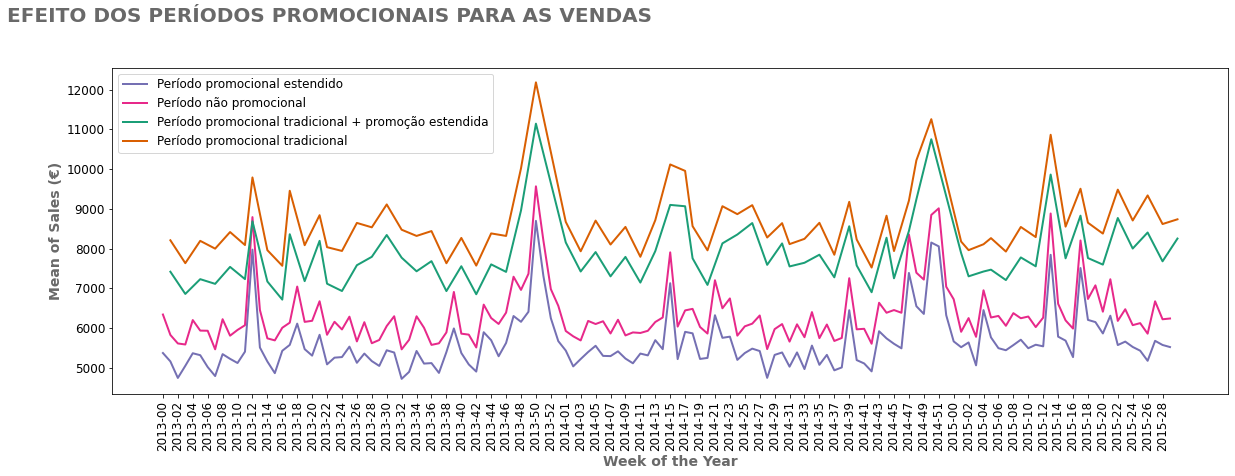

In [180]:
# Dados para cada categoria de promoção
promo_1_2 = df2[(df2['Promo'] == 1) & (df2['Promo2'] == 1)][['YearWeek', 'Sales']].groupby('YearWeek').mean().reset_index()
promo_1 = df2[(df2['Promo'] == 1) & (df2['Promo2'] == 0)][['YearWeek', 'Sales']].groupby('YearWeek').mean().reset_index()
promo_2 = df2[(df2['Promo'] == 0) & (df2['Promo2'] == 1)][['YearWeek', 'Sales']].groupby('YearWeek').mean().reset_index()
no_promo = df2[(df2['Promo'] == 0) & (df2['Promo2'] == 0)][['YearWeek', 'Sales']].groupby('YearWeek').mean().reset_index()


fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(data=promo_2, x='YearWeek', y='Sales', color='C2',
             label='Período promocional estendido', linewidth=2)
sns.lineplot(data=no_promo, x='YearWeek', y='Sales', color='C3',
             label='Período não promocional', linewidth=2)
sns.lineplot(data=promo_1_2, x='YearWeek', y='Sales',
             color='C0', label='Período promocional tradicional + promoção estendida', linewidth=2)
sns.lineplot(data=promo_1, x='YearWeek', y='Sales',
             color='C1', label='Período promocional tradicional', linewidth=2)

# Personalizar o gráfico
ax.legend(fontsize=12)
ax.set_xlabel('Week of the Year', fontsize=14,
              color='dimgrey', fontweight='bold')
ax.set_ylabel('Mean of Sales (€)', fontsize=14,
              color='dimgrey', fontweight='bold')
ax.tick_params(axis='both', labelsize=12)
ax.set_xticks(range(0, len(promo_2), 2))
ax.set_xticklabels(promo_2['YearWeek'][::2], rotation=90)

# Adicionar título geral e subtítulo à figura
fig.suptitle('EFEITO DOS PERÍODOS PROMOCIONAIS PARA AS VENDAS',
             fontsize=20, color='dimgrey', fontweight='bold', y=1.02, ha='right');

## Hipóteses sobre temporalidade

### As lojas vendem mais durante o feriado de Natal

Com base nos dados apresentados no gráfico de boxplot e na análise das medianas de vendas para cada tipo de feriado em cada ano (2013, 2014 e 2015), podemos observar que as vendas durante o período de Natal não são significativamente maiores do que em outros feriados. A mediana das vendas durante o Natal é próxima das medianas das vendas em outros feriados, como dias regulares e feriados públicos.

É interessante notar que, em termos de distribuição dos dados, o feriado de Easter Holiday apresentou a caixa mais ampla, o que sugere que houve maior variabilidade nas vendas nesse período. Além disso, quando analisamos as medianas de vendas para cada tipo de feriado em cada ano, podemos observar que em 2013 a mediana de vendas durante o feriado de Easter Holiday superou a do Natal. Por outro lado, em 2014 as vendas no período de Natal foram superiores a todos os outros tipos de feriado.

Existem algumas hipóteses que podem explicar esses resultados:

1. Embora o Natal seja um feriado importante para as famílias se reunirem e trocarem presentes, drogarias não são necessariamente o destino mais comum para compras de Natal. 

2. O feriado de Easter Holiday pode estar associado a um maior consumo de produtos específicos, como chocolates e presentes relacionados à Páscoa, o que pode levar a uma maior variabilidade nas vendas nesse período. 

Além disso, é possível que as variações nas vendas entre diferentes feriados e anos sejam influenciadas por fatores externos, como mudanças na economia ou no comportamento dos consumidores.

*Os dados das vendas durante o período de Natal de 2015 não estão disponíveis na base de dados*

In [20]:
df2[['StateHoliday','Sales']].groupby(['StateHoliday']).agg({'Sales': ['mean', 'sum']}).stb.flatten()

,StateHoliday,Sales_mean,Sales_sum
0,0,6953.96,5865164768
1,a,8487.47,5890305
2,b,9887.89,1433744
3,c,9743.75,691806


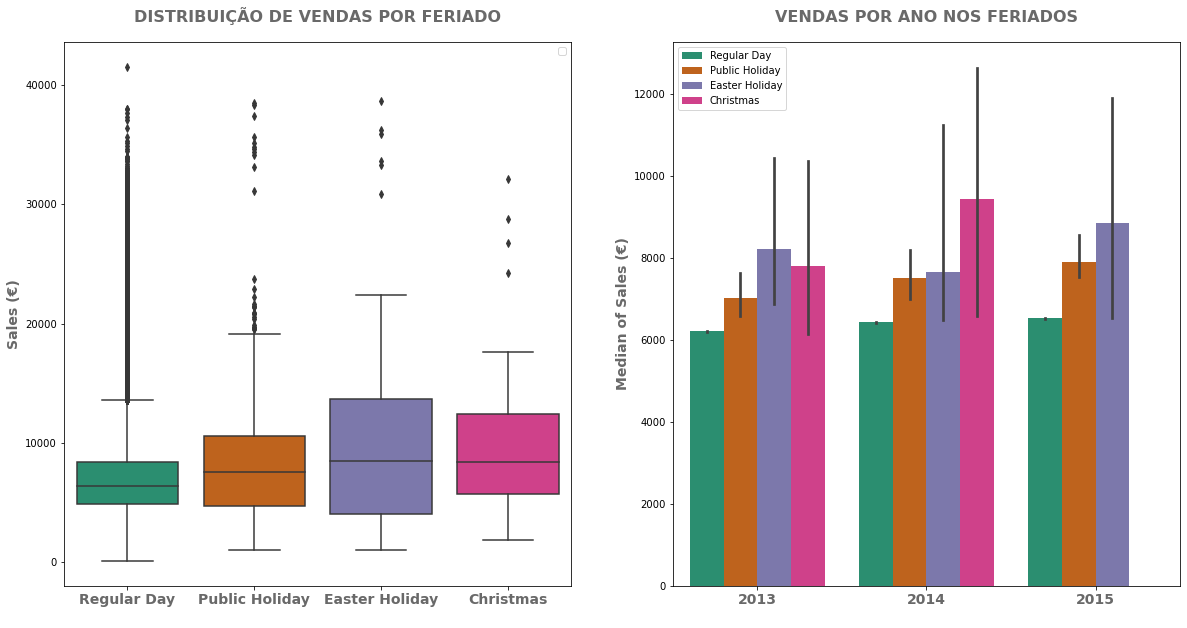

In [197]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Gráfico de Boxplot
sns.boxplot(x='StateHoliday', y='Sales', data=df2,
            palette='Dark2', ax=ax0)
ax0.set_xticklabels(
    ['Regular Day', 'Public Holiday', 'Easter Holiday', 'Christmas'], fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR FERIADO', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
ax0.set_xlabel(' ')
ax0.set_ylabel('Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
ax0.legend('')

# Gráfico de barras

# Mapear valores numéricos para nomes de feriados
holiday_names = {'0': 'Regular Day', 'a': 'Public Holiday', 'b': 'Easter Holiday', 'c': 'Christmas'}

# Plotando o gráfico
sns.barplot(x='Year', y='Sales', hue='StateHoliday',
            palette='Dark2', estimator=np.median, 
            hue_order=['0', 'a', 'b', 'c'],
            data=df2, ax=ax1)
ax1.set_title('VENDAS POR ANO NOS FERIADOS', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
ax1.set_xlabel(' ')
ax1.set_xticklabels(
    ['2013', '2014', '2015'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel('Median of Sales (€)', fontsize=14,
               color='dimgrey', fontweight='bold')
ax1.legend(title='Feriado', title_fontsize=14,
           fontsize=12, frameon=True)
# Legenda
handles, labels = ax1.get_legend_handles_labels()
labels = [holiday_names[label] for label in labels]
ax1.legend(handles, labels,
           fontsize=10, frameon=True, loc=2);

### Lojas vendem menos durante os feriados escolares

A hipótese inicial era que as vendas em lojas afetadas pelos feriados escolares seriam menores, quando comparadas com as lojas que não são afetadas. Entretanto, ao analisar o boxplot, foi observado não há uma diferença significativa entre as lojas afetadas e as não afetadas pelos feriados escolares.

Ao comparar a soma de vendas mensais entre lojas afetadas e não afetadas, foi observado que as lojas não afetadas tiveram vendas superiores em todos os meses dos anos. Além disso, é possível identificar um aumento nas vendas das lojas afetadas pelos feriados escolares em julho e agosto, o que coincide com as Férias de Verão na Alemanha. As Férias de Verão são um período de duração média de 42,5 dias que vão de julho a agosto, e isso pode explicar o aumento nas vendas dessas lojas nesse período.

A análise dos dados sugere que não há uma diferença significativa entre as vendas das lojas afetadas e não afetadas pelos feriados escolares na Alemanha. No entanto, é importante considerar que existem outros fatores que podem influenciar as vendas das lojas, e que o impacto dos feriados escolares pode variar de acordo com as diferenças regionais e outros fatores locais.

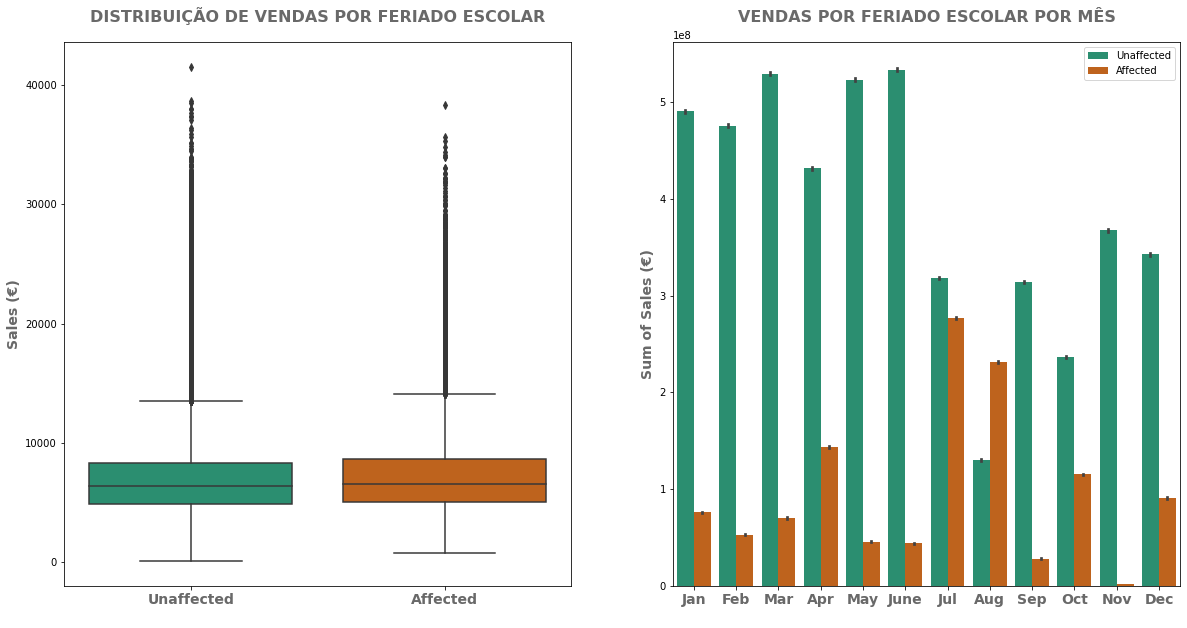

In [203]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 10))

# Boxplot
sns.boxplot(x='SchoolHoliday', y='Sales', data=df2,
            palette='Dark2', ax=ax0)
ax0.set_xticklabels(
    ['Unaffected', 'Affected'], fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_xlabel('')
ax0.set_ylabel('Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR FERIADO ESCOLAR', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
# Barplot

# Mapear valores numéricos para school holiday
school_names = {'0': 'Unaffected', '1': 'Affected'}

sns.barplot(x='Month', y='Sales', hue='SchoolHoliday',
            palette='Dark2', estimator=sum, data=df2, ax=ax1)
ax1.set_xticklabels(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_xlabel(' ')
ax1.set_ylabel('Sum of Sales (€)', fontsize=14,
               color='dimgrey', fontweight='bold')
ax1.set_title('VENDAS POR FERIADO ESCOLAR POR MÊS', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')
ax1.legend(bbox_to_anchor=(1, 1), loc=2)
# Legenda
handles, labels = ax1.get_legend_handles_labels()
labels = [school_names[label] for label in labels]
ax1.legend(handles, labels,
           fontsize=10, frameon=True);

### Lojas vendem menos aos finais de semana

A hipótese inicial de que as vendas seriam menores nos finais de semana pode estar relacionada ao fato de que muitas pessoas têm mais tempo livre nesses dias e podem preferir fazer outras atividades em vez de ir às compras. Além disso, é possível que o trânsito e a dificuldade de encontrar estacionamento nas grandes cidades durante os finais de semana possam desencorajar as pessoas a saírem de casa para fazer compras.

No entanto, a análise do boxplot não permitiu afirmar que existe uma diferença significativa entre as vendas dos diferentes dias da semana. Curiosamente, os menores valores de venda foram registrados aos sábados, enquanto o domingo apresenta apresenta uma maior dispersão, ou seja, há mais variabilidade nos valores das vendas. Ao analisar as vendas totais, foi possível observar que o maior somatório de vendas ocorre na segunda-feira e diminui ao longo dos dias da semana, sendo o menor somatório no domingo. Uma hipótese para essa queda nas vendas ao longo da semana pode estar relacionada ao fato de que muitas pessoas preferem fazer compras no início da semana, principalmente após o recebimento do salário. Além disso, é possível que a demanda por produtos em uma rede de drogarias seja maior no início da semana, já que muitas pessoas aproveitam esse momento para fazer suas compras semanais.

Em conclusão, embora a análise do boxplot não tenha permitido afirmar que existe uma diferença significativa entre as vendas nos diferentes dias da semana em uma rede de drogarias, foi possível observar uma tendência de queda nas vendas ao longo da semana, com o menor somatório de vendas ocorrendo no domingo.

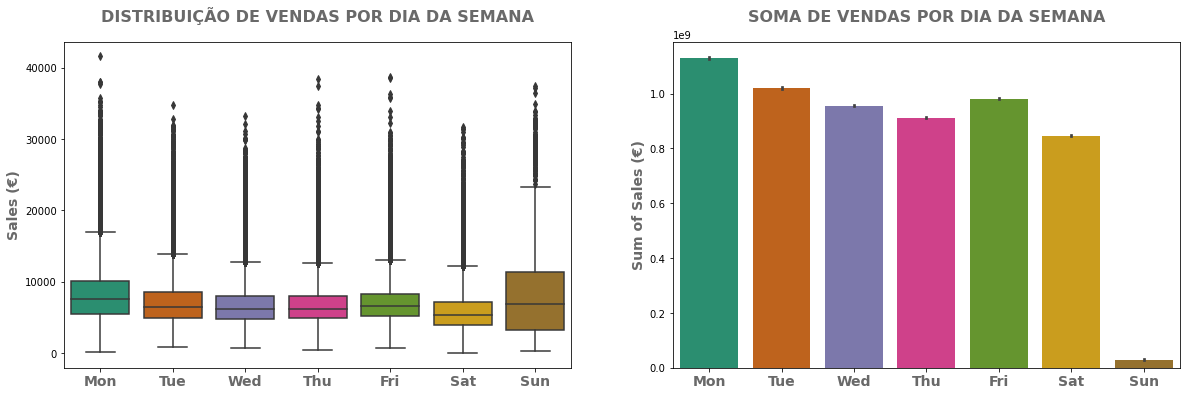

In [204]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 6))
# Barplot
sns.boxplot(x='DayOfWeek', y='Sales', palette='Dark2', data=df2, ax=ax0)
ax0.set_xticklabels(
    ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_xlabel(' ')
ax0.set_ylabel('Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR DIA DA SEMANA', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold')

sns.barplot(x='DayOfWeek', y='Sales', palette='Dark2',
            data=df2, estimator=sum, ax=ax1)
ax1.set_xticklabels(
    ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_xlabel(' ')
ax1.set_ylabel('Sum of Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_title('SOMA DE VENDAS POR DIA DA SEMANA', pad=20,
              fontsize=16, color='dimgrey', fontweight='bold');

###  As vendas aumentam durante o inverno
  
  Foi esperado que as vendas sofressem influências sazonais, com um aumento nas vendas durante o inverno. No entanto, ao analisar os dados em um boxplot, não foram encontradas diferenças significativas entre as vendas durante as estações do ano. Embora tenha sido observado um aumento nas vendas durante a primavera e o inverno no ano de 2014, e um aumento nas vendas durante a primavera em relação às outras estações em 2015, é importante ressaltar que não foram obtidos dados referentes às vendas durante o inverno de 2015.

Diante desses resultados, pode-se formular algumas hipóteses. Talvez a influência sazonal sobre as vendas não seja tão significativa quanto o esperado, ou pode ser que outros fatores tenham influenciado nas vendas durante essas estações do ano, tais como promoções específicas ou mudanças nos hábitos de consumo dos clientes. Além disso, pode-se levantar a hipótese de que as condições climáticas em determinadas regiões tenham afetado as vendas de maneira diferente, o que pode ser explorado em estudos futuros.

In [25]:
df2[['Season','Sales']].groupby(['Season']).agg({'Sales': ['mean', 'sum']}).stb.flatten()

,Season,Sales_mean,Sales_sum
0,Fall,6776.18,1063947736
1,Spring,7041.87,1744975418
2,Summer,6896.91,1534963182
3,Winter,7048.51,1529294287


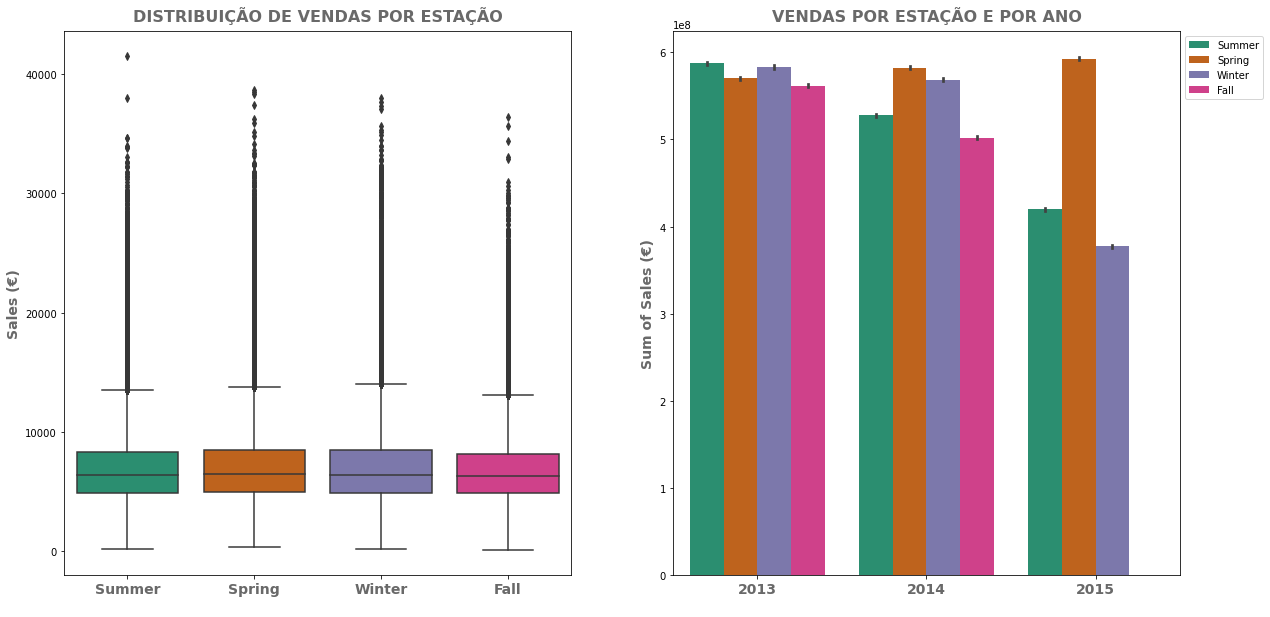

In [207]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(20, 10))

# Barplot
sns.boxplot(x='Season', y='Sales', palette='Dark2', data=df2, ax=ax0)
ax0.set_xlabel(' ')
ax0.set_xticklabels(
    ['Summer', 'Spring', 'Winter', 'Fall'], fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_ylabel('Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
ax0.set_title('DISTRIBUIÇÃO DE VENDAS POR ESTAÇÃO', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')

# Barplot
sns.barplot(x='Year', y='Sales', hue='Season',
            palette='Dark2', estimator=sum, data=df2, ax=ax1)
ax1.set_xlabel(' ')
ax1.set_xticklabels(
    ['2013', '2014', '2015'], fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_ylabel('Sum of Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
ax1.set_title('VENDAS POR ESTAÇÃO E POR ANO', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')
ax1.legend(bbox_to_anchor=(1, 1), loc=2);

### PADRÃO DE VENDAS DURANTE 2013, 2014 E 2015

Ao analisar o gráfico de linhas referente às vendas nos anos de 2013, 2014 e 2015, é possível observar alguns padrões de comportamento. Em 2013, os picos de vendas ocorreram em março, julho e dezembro, com o mês de dezembro sendo o período que apresentou as maiores vendas. No ano de 2014, houve um platô nas vendas de março até junho, seguido por uma queda que persistiu até novembro, com o pico de vendas sendo registrado em dezembro.

No entanto, para o ano de 2015, os dados não estão completos, mas podemos observar que o comportamento das vendas nos primeiros sete meses do ano foi semelhante ao do ano anterior. Os picos de vendas foram registrados em março e julho, enquanto as vendas mais baixas foram registradas em fevereiro e maio.

Com base nesses padrões, é possível formular algumas hipóteses. Pode ser que a sazonalidade tenha influenciado nas vendas, com determinados meses sendo mais propícios para as compras do que outros. Outra hipótese é que as campanhas promocionais possam ter afetado as vendas, especialmente em períodos de pico, como dezembro.

In [184]:
# Meses
months = list(calendar.month_name)[1:]

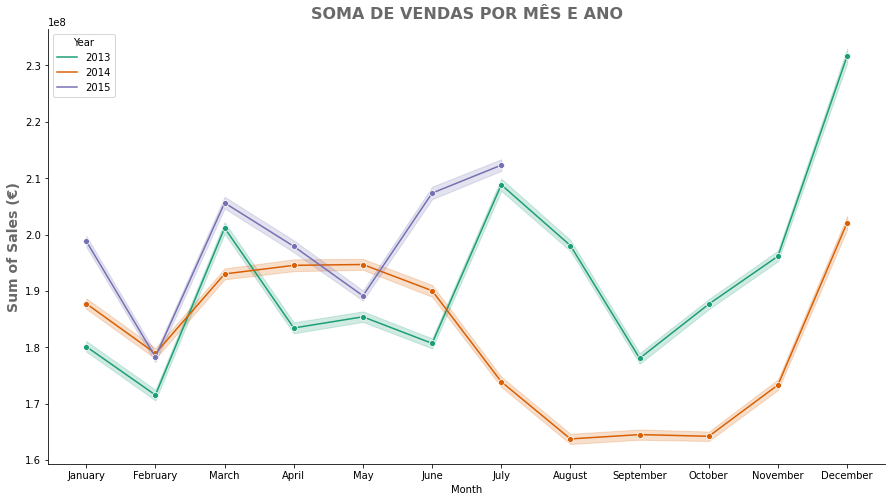

In [187]:
# Gráfico de linhas
sns.lineplot(data=df2, x='Month', y='Sales', estimator=sum, hue='Year',  marker='o', palette='Dark2')
sns.despine()

# Adicionando os títulos para o gráfico e para os eixos x e y
plt.title('SOMA DE VENDAS POR MÊS E ANO', pad=10,
              fontsize=16, color='dimgrey', fontweight='bold')
plt.ylabel('Sum of Sales (€)', fontsize=14, color='dimgrey', fontweight='bold')
plt.xticks(range(1, 13), months);

## Verificando correlações

### Variáveis numéricas

Ao analisar a matriz de correlação, foi possível observar que há uma forte correlação positiva entre as variáveis **Sales** e **Customers** com um valor de 0,82. Isso sugere que o aumento das vendas de uma loja está relacionado com o aumento do número de clientes que frequentam a mesma.

Além disso, foi identificada uma correlação positiva moderada de 0,37 entre as variáveis **Promo** e **Sales**, o que sugere que a promoção de produtos ou serviços pode estar relacionada com um aumento nas vendas.

No entanto, é importante lembrar que correlação não implica causalidade, ou seja, a simples associação entre duas variáveis não significa que uma cause a outra. Outros fatores podem estar envolvidos, e análises adicionais podem ser necessárias para entender melhor as relações entre as variáveis em questão.

 - Relação entre vendas e clientes

Text(0.5, 0.98, 'Relação entre Número de Clientes e Vendas')

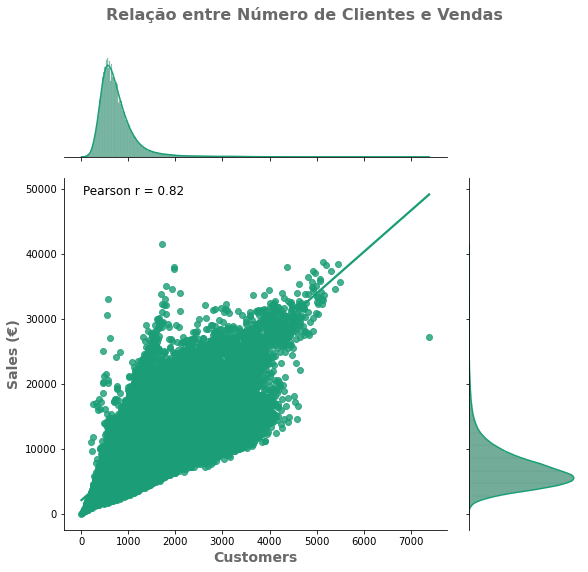

In [211]:
# Gráfico de dispersão com histogramas
g = sns.jointplot(x='Customers', y='Sales', data=df2, kind='reg', height=8, ratio=3)

# Cálculo do coeficiente de correlação de Pearson
corr_coef, _ = pearsonr(df2['Customers'], df2['Sales'])

# Adição do valor do coeficiente de correlação no gráfico
g.ax_joint.annotate(f'Pearson r = {corr_coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

# Ajuste título
g.fig.subplots_adjust(top=0.9)

# Adição do título
g.set_axis_labels('Customers', 'Sales (€)', fontsize=14, fontweight='bold', color='dimgrey')
g.fig.suptitle('Relação entre Número de Clientes e Vendas', fontsize=16, fontweight='bold', color='dimgrey')

In [122]:
df_corr = df2.corr()

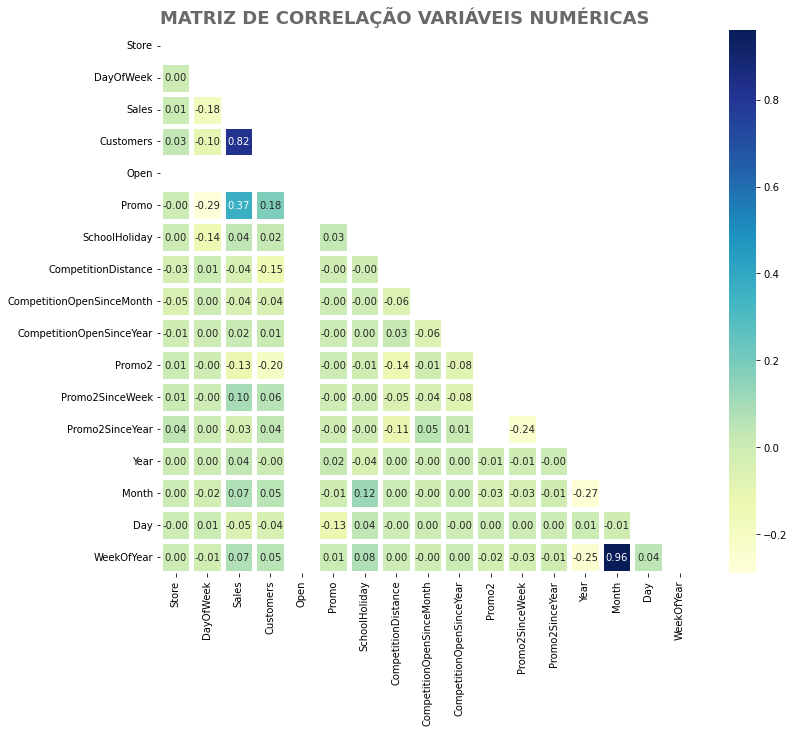

In [124]:
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr, ax=ax, cmap='YlGnBu', annot=True,
            fmt='.2f', linewidths=5, mask=mask)
plt.title('MATRIZ DE CORRELAÇÃO VARIÁVEIS NUMÉRICAS', loc='left',
          fontsize=18, color='dimgrey', fontweight='bold')

### Cramer V: variáveis categóricas

O Cramer V é uma medida de associação entre variáveis categóricas. Ele é utilizado para avaliar o grau de dependência entre duas variáveis categóricas, indicando a força da relação entre elas. O coeficiente de Cramer V varia de 0 a 1, sendo que valores próximos de 0 indicam ausência de associação entre as variáveis e valores próximos de 1 indicam uma associação forte entre elas. O Cramer V é uma medida normalizada, o que significa que o seu valor é independente do número de categorias em cada variável.

Ao utilizar o Cramer V para analisar a força das correlações entre variáveis categóricas, foi verificado que as variáveis StoreType e Assortment apresentaram uma correlação de 0.54. A correlação moderada entre **StoreType** e **Assortment** pode indicar que há uma relação entre o tipo de loja (StoreType) e o tipo de sortimento de produtos vendidos (Assortment). É importante lembrar que o Cramer V é uma medida de associação entre variáveis categóricas e não indica causalidade. Ou seja, a correlação entre StoreType e Assortment não significa necessariamente que uma variável causa a outra.

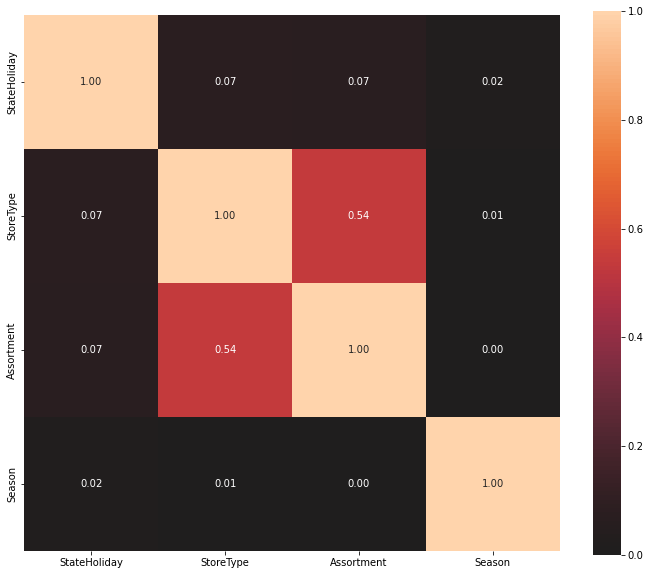

{'corr':               StateHoliday  StoreType  Assortment  Season
 StateHoliday          1.00       0.07        0.07    0.02
 StoreType             0.07       1.00        0.54    0.01
 Assortment            0.07       0.54        1.00    0.00
 Season                0.02       0.01        0.00    1.00,
 'ax': <AxesSubplot:>}

In [31]:
categorical = df2[['StateHoliday', 'StoreType', 'Assortment', 'Season']]
# Calculate Cramer V
associations(categorical, figsize=(12, 10))

# CONCLUSÕES DA EDA

  A falta de informações sobre o perfil dos clientes e a localização das lojas limita a capacidade de entender completamente os padrões de vendas na análise exploratória de dados. Sem essas informações, não é possível determinar quais grupos de clientes são mais propensos a comprar determinados produtos e quais lojas estão em áreas mais ou menos populosas, por exemplo. Além disso, sem informações sobre a localização das lojas, não foi possível avaliar a concorrência em áreas específicas. Para superar essas limitações, dados externos como informações demográficas do bairro, dados sobre o mercado local e concorrência podem ser úteis para compreender melhor o comportamento de compra dos clientes em diferentes áreas e como isso afeta as vendas. Com essas informações adicionais, pode-se desenvolver uma análise mais completa e eficaz para entender as tendências e padrões nas vendas.

# PREPARAÇÃO DOS DADOS - BORUTA

## Split dos dados para Boruta

In [128]:
df3 = df2.copy()

In [129]:
cols_drop = ['Customers', 'Open']
df3 = df3.drop(cols_drop, axis=1)

In [130]:
df3['Sales'] = np.log1p( df3['Sales'] )

In [131]:
df3.shape

(844392, 22)

In [132]:
# Verificar data do primeiro dia das últimas 6 semanas: 42 dias
df3[['Store', 'Date'
     ]].groupby('Store').max().reset_index()['Date'][0] - datetime.timedelta(
         days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [133]:
# Define a data limite para separar entre treino e teste
limite_data = '2015-06-19'

# Separa os dados em treino e teste
train = df3[df3['Date'] < limite_data]
test = df3[df3['Date'] >= limite_data]

# Remove a variável resposta 'Sales' do conjunto de treino
train_X = train.drop('Sales', axis=1)
train_y = train['Sales']

## Preparação dos dados para Boruta

In [58]:
train_X.head()

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,YearWeek,Season
47945,1,4,2015-06-18,1,0,0,c,a,1270.00,9.00,...,0,NaN,NaN,NaN,2015,6,18,25,2015-24,Summer
47946,2,4,2015-06-18,1,0,0,a,a,570.00,11.00,...,1,13.00,2010.00,"Jan,Apr,Jul,Oct",2015,6,18,25,2015-24,Summer
47947,3,4,2015-06-18,1,0,0,a,a,14130.00,12.00,...,1,14.00,2011.00,"Jan,Apr,Jul,Oct",2015,6,18,25,2015-24,Summer
47948,4,4,2015-06-18,1,0,0,c,c,620.00,9.00,...,0,NaN,NaN,NaN,2015,6,18,25,2015-24,Summer
47949,5,4,2015-06-18,1,0,0,a,a,29910.00,4.00,...,0,NaN,NaN,NaN,2015,6,18,25,2015-24,Summer


### Handling missing values

As colunas com valores ausentes são: 
- Promo2SinceWeek
- PromoSinceYear
- PromoInterval
- CompetitionOpenSinceYear
- CompetitionOpenSinceMonth	
- CompetitionDistance

In [134]:
# Preenchendo missing values
train_X = handle_missing_values(train_X)
train_X = handle_missing_values(train_X)

In [135]:
# Verificando missing values
train_X.stb.missing()

,missing,total,percent
Store,0,802996,0.00
Promo2,0,802996,0.00
YearWeek,0,802996,0.00
WeekOfYear,0,802996,0.00
Day,0,802996,0.00
Month,0,802996,0.00
Year,0,802996,0.00
PromoInterval,0,802996,0.00
Promo2SinceYear,0,802996,0.00
Promo2SinceWeek,0,802996,0.00


In [136]:
# Convertendo tipos de dados
train_X['CompetitionOpenSinceMonth'] = train_X['CompetitionOpenSinceMonth'].astype(int)
train_X['CompetitionOpenSinceYear'] = train_X['CompetitionOpenSinceYear'].astype(int)
train_X['Promo2SinceWeek'] = train_X['Promo2SinceWeek'].astype(int)
train_X['Promo2SinceYear'] = train_X['Promo2SinceYear'].astype(int)

### Feature Engineering

**Novas features:**

    - CompetitionSince: essa coluna foi criada para calcular quanto tempo a loja tem competidores
    próximos a ela. A partir das informações de competition_open_since_year e competition_open_since_month, que indicam o ano e mês em que o competidor mais antigo próximo à loja foi aberto, é criada uma data (no formato datetime) que representa o início da competição. 
    
    - CompetitionTimeMonth: essa coluna indica há quantos meses a competição próxima à loja está ocorrendo. É calculada a partir da diferença entre a data da análise (Date) e a data de início da competição (CompetitionSince), em meses.
    
    - Promo2Since: calcula o tempo desde a promoção 2 em meses. É feita uma subtração entre o ano atual (coluna 'Year') e o ano de início da promoção (coluna 'Promo2SinceYear') multiplicado por 12, mais uma subtração entre a semana do no atual (coluna 'WeekOfYear') e a semana de início da promoção (coluna 'Promo2SinceWeek') multiplicado por 0.230137, que representa o fator de conversão para transformar semanas em meses.

In [137]:
# Competition
train_X['CompetitionSince'] = pd.to_datetime(
    train_X['CompetitionOpenSinceYear'].astype(
        str) + '-' + train_X['CompetitionOpenSinceMonth'].astype(str) + '-01'
)

train_X['CompetitionTimeMonth'] = (
    (train_X['Date'] - train_X['CompetitionSince']) / np.timedelta64(1, 'M')).astype(int)

In [138]:
# Promo Since
promo2since = ((train_X['Year'] - train_X['Promo2SinceYear']) * 12 +
               (train_X['WeekOfYear'] - train_X['Promo2SinceWeek']) * 0.230137)
train_X['Promo2Since'] = promo2since.clip(lower=0) * train_X['Promo2']

In [139]:
# Transformação em coordenadas polares para preservar a ordem circular
train_X = day_week_month_transform(train_X)

In [140]:
# Excluindo colunas desnecessárias
cols_drop = ['Month', 'Day', 'DayOfWeek','WeekOfYear', 'YearWeek', 'Promo2SinceWeek', 'Promo2SinceYear',
             'PromoInterval','CompetitionSince', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
train_X = train_X.drop(cols_drop, axis=1)
train_X.head()

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,...,CompetitionTimeMonth,Promo2Since,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Day_sin,Day_cos,WeekOfYear_sin,WeekOfYear_cos
47945,1,2015-06-18,1,0,0,c,a,1270.00,0,2015,...,81,0.00,-0.43,-0.90,0.00,-1.00,-0.59,-0.81,0.12,-0.99
47946,2,2015-06-18,1,0,0,a,a,570.00,1,2015,...,91,62.76,-0.43,-0.90,0.00,-1.00,-0.59,-0.81,0.12,-0.99
47947,3,2015-06-18,1,0,0,a,a,14130.00,1,2015,...,102,50.53,-0.43,-0.90,0.00,-1.00,-0.59,-0.81,0.12,-0.99
47948,4,2015-06-18,1,0,0,c,c,620.00,0,2015,...,69,0.00,-0.43,-0.90,0.00,-1.00,-0.59,-0.81,0.12,-0.99
47949,5,2015-06-18,1,0,0,a,a,29910.00,0,2015,...,2,0.00,-0.43,-0.90,0.00,-1.00,-0.59,-0.81,0.12,-0.99


## Pré processamento para dados numéricos

### Rescaling

In [141]:
# Transformação variável resposta
train_y = np.log1p(train_y)

In [142]:
# Scaling
rs = RobustScaler()
mms = MinMaxScaler()

# CompetitionDistance
train_X['CompetitionDistance'] = rs.fit_transform(
    train_X[['CompetitionDistance']].values)

# Competition Time Month
train_X['CompetitionTimeMonth'] = rs.fit_transform(
    train_X[['CompetitionTimeMonth']].values)

# Competition Time Month
train_X['Promo2Since'] = rs.fit_transform(
    train_X[['Promo2Since']].values)

# Year
train_X['Year'] = mms.fit_transform(train_X[['Year']].values)

## Pré processamento para dados categóricos

### Encoding

In [143]:
# Encoding

# StateHoliday - One Hot
train_X = pd.get_dummies(train_X,
                         prefix=['StateHoliday'],
                         columns=['StateHoliday'])
# Season
train_X = pd.get_dummies(train_X,
                        prefix=['Season'],
                        columns=['Season'])

# Store Type
train_X = pd.get_dummies(train_X,
                       prefix=['StoreType'],
                       columns=['StoreType'])

# assortment - ordinal
assortment_dict = {'a': 1, 'b': 2, 'c': 3}

train_X['Assortment'] = train_X['Assortment'].map(assortment_dict)

# FEATURE SELECTION: BORUTA

- Rodar a seleção pelo Boruta somente uma vez.

In [71]:
# train for boruta
#X_train_n = train_X.drop(['Date'], axis=1)
#y_train_n = train_y.values.ravel()

# Algorithm for boruta
#rf = RandomForestRegressor(n_jobs=-1)
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
#boruta.fit(X_train_n.values, train_y.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	19
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	19
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	19
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	19
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	19
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	19
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	19
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	19
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	19
I

BorutaPy(estimator=RandomForestRegressor(n_estimators=37, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x1F534F5E640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1F534F5E640, verbose=2)

- O Boruta iterou 50 vezes, confirmou apenas 6 variáveis como relevantes e rejeitou 23 variáveis. 

## Selecionando as variáveis rankeadas como relevantes pelo Boruta

In [72]:
#boruta.support_
#selected_columns= X_train_n.columns[boruta.support_]
#X_selected = X_train_n[selected_columns]

In [73]:
#X_selected.columns

Index(['Store', 'Promo', 'CompetitionDistance', 'CompetitionTimeMonth',
       'Promo2Since', 'DayOfWeek_cos'],
      dtype='object')

In [144]:
#cols_selected_boruta = [['Store', 'Promo', 'CompetitionDistance', 'CompetitionTimeMonth','Promo2Since', 'DayOfWeek_cos']]

# PRÓXIMOS PASSOS:

Os próximos passos do projeto para previsão de vendas consistem na:

    1 - Aplicação de diversos modelos de machine learning 
    2 - Realização de validação cruzada
    3 - Seleção do modelo com base no erro quadrático médio raiz (RMSE) 
    4 - Ajuste de Hiperparâmetros com Random Search 
    5 - Obtenção do modelo final e implantação do modelo. 

Essas etapas têm como objetivo aprimorar a precisão do modelo de previsão de vendas, tornando-o mais eficaz na tomada de decisões.